#  Comparing Hyperparameter Optimization Frameworks

In [112]:
__author__ = 'Gerben Tempelman'

The paramater grids and distributions for the LightGBM model are constructed using the LightGBM documentation. The following website provides a nice overview of the parameters and their influence:

https://sites.google.com/view/lauraepp/parameters

I chose a fixed learning rate, as was mentioned:

_"Once your learning rate is fixed, do not change it. It is not a good practice to consider the learning rate as a hyperparameter to tune. learning rate should be tuned according to your training speed and performance trade-off. Do not let an optimizer tune it."_

## 1.1 Imports

In [2]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import _pickle as pickle
import bz2
from timeit import default_timer as timer
import lightgbm as lgb
from scipy import stats
from collections import OrderedDict
import inspect
import warnings
import matplotlib
import plotly.graph_objs as go
import random 
warnings.filterwarnings('ignore')
random.seed(22)

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import skopt
from skopt import dump, load
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt import forest_minimize, gbrt_minimize, gp_minimize, dummy_minimize
from skopt.plots import plot_convergence, plot_evaluations, plot_objective

from hyperopt import hp, STATUS_OK, Trials, fmin, tpe, atpe, rand

import optuna
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice
from optuna.pruners import SuccessiveHalvingPruner
from optuna.integration import OptunaSearchCV
import optuna.integration.lightgbm as lgb_optuna # available in 0.18.0, special implementation for LightGBM

## 1.2 Utils

In [3]:
def append_mdl_dct(data, kind, name, library, API_method, surrogate_model, acquisition_function
                   , train_score, test_score, time_min, study_object, best_model, SEED):
    """Function that builds a dictionary with model iterations + results"""
    vals = locals()
    if 'library' not in mdl_dct.keys():
        for k, v in vals.items():
            mdl_dct[k] = [v]
        
    else:
        for k, v in vals.items():
            mdl_dct[k].append(v)

def opt_deco(func):
    def timeit(**kwargs):
        """Decorator abstract away other complexities. This decorator
        times the number of minutes of execution of functions, and
        adds results to the model dictionary"""
        
        # put all values of params of func in dict
        param_dct = {}
        for x, y in zip(list(inspect.getfullargspec(func).args), list(inspect.getfullargspec(func).defaults)):
            param_dct[x] = y

        # overwrite default args of func with kwargs
        for k,v  in kwargs.items():
            param_dct[k] = v
        
        # time function
        def inner():
            print(f"\n >>> Estimating models for: {param_dct['name']}")
            start = timer()
            best_model, study, train_score, test_score = func(**kwargs)
            runtime = np.round((timer() - start)/60, 3)
            print(f'Model estimation took {runtime} minutes')

            # appending results to dict
            append_mdl_dct(data = param_dct['data']  
               , kind = param_dct['kind']
               , name = param_dct['name'] 
               , library = param_dct['lib']
               , API_method = param_dct['api_method']
               , surrogate_model = param_dct['surrogate']
               , acquisition_function = param_dct['acquisition']
               , train_score = train_score
               , test_score = test_score
               , time_min = runtime
               , study_object = study
               , best_model = best_model
               , SEED = param_dct['SEED'])
            
            print('>>> Finished estimating models')   
        return inner()
    return timeit

## 1.3 Load data

In [71]:
def load_data(SEED = 1993):
    data_dct = {}
    
    for dataset in ['OttoGroup', 'SatImage', 'Shuttle']:
        df = pd.read_csv(f'Datasets\\{dataset}\\train.csv')
        
        if dataset == 'OttoGroup':
            y = df.pop('target')
            
        if dataset == 'Shuttle':
            df['class'] = df['class'].astype(str)
            
        if dataset in ['SatImage', 'Shuttle']:
            y = df.pop('class')
            
        X_train, X_valid, y_train, y_valid = train_test_split(df
                                                              , y
                                                              , test_size=0.2
                                                              , random_state=SEED
                                                              , stratify=y)

        if dataset in ['OttoGroup', 'Shuttle']: 
            def transform_y(y):
                y_lab = y.apply(lambda x: x.replace('Class_', ''))
                return y_lab.astype(int) - 1 #offset for multilabel classification should be 0! Otherwise estimation will fail.

            y_train = transform_y(y_train)
            y_valid = transform_y(y_valid)

        if dataset == 'SatImage':
            y_train = y_train.replace(7,6)
            y_valid = y_valid.replace(7,6)
            y_train = y_train.astype(int)-1
            y_valid = y_valid.astype(int)-1
        
        data_dct[dataset] = [X_train, y_train, X_valid, y_valid]
    
    return data_dct

data_dct = load_data(SEED = 1993)

## 2. Models

## 2.1 Baseline Model

In [5]:
@opt_deco
def baseline_model(data = 'OttoGroup'
                   , kind = 'Exhaustive'
                   , name = 'Baseline Model'
                   , lib = 'None'
                   , api_method = 'LightGBM baseclassifier'
                   , surrogate = 'None'
                   , acquisition = 'None'
                   , SEED = 1993):

    X_train, y_train, X_valid, y_valid = data_dct[data]
    
    clf = lgb.LGBMClassifier(n_jobs = -1
                                  , objective = 'multiclass'
                                  , n_estimators = 100
                                  , random_state= SEED)

    cv_scores = cross_val_score(clf
                                , X_train
                                , y_train
                                , cv = 5
                                , scoring='neg_log_loss')

    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_valid)

    # get scores
    train_score = np.negative(np.round(np.mean(cv_scores)*100, 2))
    print(f'Cross-validated log loss on train set: {train_score}')

    test_score = np.round(log_loss(y_valid, y_pred)*100,2)
    print(f'Log loss on test set: {test_score}')

    return clf, clf, train_score, test_score

## 2.2 Exhaustive Methods

### Grid search

In [6]:
@opt_deco
def grid_search(data = 'OttoGroup'
                   , kind = 'Exhaustive'
                   , name = 'Grid Search'
                   , lib = 'Scikit-learn'
                   , api_method = 'GridSearchCV'
                   , surrogate = 'None'
                   , acquisition = 'None'
                   , SEED = 1993):

    X_train, y_train, X_valid, y_valid = data_dct[data]
    
    # define paramgrid
    param_grid = {'boosting_type': ['gbdt', 'dart', 'goss'], 
                  'num_leaves': [31,63,127,255], 
                  'max_depth': [-1, 3, 5, 10], 
                  'n_estimators':[100, 300], 
                }


    # fit model
    lgbm_clf = lgb.LGBMClassifier(n_jobs = -1
                                  , objective = 'multiclass'
                                  , learning_rate = 0.05
                                  , random_state= SEED)

    grid = GridSearchCV(lgbm_clf
                        , param_grid = param_grid
                        , cv = 5
                        , scoring= 'neg_log_loss'
                        , verbose=True
                        , n_jobs= -1)

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict_proba(X_valid)

    # get scores
    train_score = np.negative(np.round(grid.best_score_*100, 2))
    print(f'Cross-validated log loss on train set: {train_score}')

    test_score = np.round(log_loss(y_valid, y_pred)*100,2)
    print(f'Log loss on test set: {test_score}')

    return best_model, grid, train_score, test_score

### Randomized Search

In [7]:
@opt_deco
def random_search(data = 'OttoGroup'
                   , kind = 'Exhaustive'
                   , name = 'Randomized Search'
                   , lib = 'Scikit-learn'
                   , api_method = 'RandomizedSearchCV'
                   , surrogate = 'None'
                   , acquisition = 'None'
                   , SEED = 1993):

    X_train, y_train, X_valid, y_valid = data_dct[data]

    # define paramgrid
    # **leave it alone unless you know what your doing
    param_grid = {'boosting_type': ['gbdt', 'dart', 'goss'], #major
                  'num_leaves': [15,31,63,127,255], #major
                  'max_depth': [-1, 2, 3, 5, 7, 10, 12], #major
                  'n_estimators':[100, 300], #major
                  'subsample_for_bin': [20000, 50000, 100000, 200000], #minor, 
                  'class_weight': [None, 'balanced'], #minor**
                  'min_split_gain': [0], #minor**
                  'min_child_weight':[1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4], #minor**
                  'min_child_samples': stats.randint(1, 100), #minor**
                  'subsample': [0.2, 0.4, 0.6, 0.8, 1], #major, <1!
                  'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1], #major, <1!
                  'reg_alpha': [0], #minor**
                  'reg_lambda': [0] #minor**
                  }
    
    # fit model
    lgbm_clf = lgb.LGBMClassifier(n_jobs = -1
                                  , objective = 'multiclass'
                                  , learning_rate = 0.05 # do not tune learning rate; bad practice
                                  , random_state= SEED)

    grid = RandomizedSearchCV(lgbm_clf
                              , param_distributions = param_grid
                              , n_iter = 150
                              , cv = 5
                              , scoring= 'neg_log_loss'
                              , verbose=True
                              , n_jobs=-1
                              , random_state= SEED)

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict_proba(X_valid)

    # get scores
    train_score = np.negative(np.round(grid.best_score_*100, 2))
    print(f'Cross-validated log loss on train set: {train_score}')

    test_score = np.round(log_loss(y_valid, y_pred)*100,2)
    print(f'Log loss on test set: {test_score}')

    return best_model, grid, train_score, test_score

## 2.3 Sequential Model-Based Optimization (SMBO)

### Skopt - BayesianSearchCV

Scikit-optimize provides a drop-in replacement for GridSearchCV, which 
utilizes Bayesian Optimization where a predictive model referred to as 
"surrogate" is used to model the search space and utilized to arrive at good 
parameter values combination as soon as possible.

- Great documentation
- Nice plotting features
- Cannot distribute over a cluster of machines

In [8]:
@opt_deco
def bayesian_search(data = 'OttoGroup'
                   , kind = 'SMBO'
                   , name = 'Bayesian Search'
                   , lib = 'Scikit-Optimize'
                   , api_method = 'BayesSearchCV'
                   , surrogate = 'GP'
                   , acquisition = 'gp_hedge'
                   , SEED = 1993):

    X_train, y_train, X_valid, y_valid = data_dct[data]

    # define paramgrid, only Real, Integer, and Categorical supported
    # no nested search spaces
    param_grid ={
        'boosting_type': Categorical(['gbdt', 'dart', 'goss'])
        ,'num_leaves': Categorical([15,31,63,127,255])
        ,'max_depth': Integer(-1, 12, 'uniform')
        ,'n_estimators': Categorical([100, 300])
        ,'subsample_for_bin': Categorical([20000, 50000, 100000, 200000])
        ,'class_weight': Categorical([None, 'balanced'])
        ,'min_child_weight': Categorical([1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4])         
        ,'min_child_samples': Integer(1, 100, 'uniform')
        ,'subsample': Real(0.2, 1.0, 'uniform')
        ,'colsample_bytree': Real(0.2, 1.0, 'uniform')
        }
    
    # fit model
    lgbm_clf = lgb.LGBMClassifier(n_jobs = -1
                                  , objective = 'multiclass'
                                  , learning_rate = 0.05
                                  , random_state= SEED)

    study = BayesSearchCV(estimator = lgbm_clf
        , search_spaces = param_grid
        , scoring = 'neg_log_loss'
        , n_iter = 70 # budget 
        , random_state=SEED
        , cv=5
        , n_jobs = -1
    )

    study.fit(X_train, y_train)
    best_model = study.best_estimator_
    y_pred = best_model.predict_proba(X_valid)

    # get scores
    train_score = np.negative(np.round(study.best_score_*100, 2))
    print(f'Cross-validated log loss on train set: {train_score}')

    test_score = np.round(log_loss(y_valid, y_pred)*100,2)
    print(f'Log loss on test set: {test_score }')

    return best_model, study, train_score, test_score

### Skopt Optimizers

Skopt makes use of several surorgate optimizers that can minimize a function.
Each optimizer uses one of the provided acquisition functions to determine
what is the most interesting part of the search space to explore next.

In [9]:
@opt_deco
def skopt_opt(data = 'OttoGroup'
                   , kind = 'SMBO'
                   , name = 'Bayesian Search'
                   , lib = 'Scikit-Optimize'
                   , api_method = ''
                   , surrogate = ''
                   , acquisition = 'gp_hedge'
                   , SEED = 1993):
    
    # check input
    if api_method not in ['gbrt_minimize', 'dummy_minimize', 'gp_minimize', 'forest_minimize']:
        raise ValueError('api_method input is not valid')
    
    method_dct = {
    'forest_minimize': forest_minimize
    ,'gbrt_minimize': gbrt_minimize
    ,'dummy_minimize': dummy_minimize
    ,'gp_minimize': gp_minimize
    }
    
    optimizer = method_dct[api_method]
    
    # data
    X_train, y_train, X_valid, y_valid = data_dct[data]
    train_data = lgb.Dataset(X_train, label=y_train)
    
    # define search space, note that this is a list rather than a dict
    search_space = [
        Categorical(['gbdt', 'dart', 'goss'], name = 'boosting_type')
        ,Categorical([15,31,63,127,255], name = 'num_leaves')
        ,Integer(-1, 12, name = 'max_depth', prior = 'uniform')
        ,Categorical([20000, 50000, 100000, 200000], name = 'subsample_for_bin')
        ,Categorical([None, 'balanced'], name = 'class_weight')
        ,Categorical([1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4], name = 'min_child_weight')
        ,Integer(1, 1000, name = 'min_child_samples', prior = 'uniform')
        ,Real(0.2, 1.0, name = 'subsample', prior = 'uniform')
        ,Categorical([0.05], name = 'learning_rate')
        ,Real(0.2, 1.0, name = 'colsample_bytree', prior = 'uniform')
        ]
    
    score_hotseat = 0
    opt_rounds = None
    
    # decorator allows the objective function to receive the params as **kwargs. 
    @skopt.utils.use_named_args(search_space)
    def objective(**params):
        nonlocal score_hotseat
        nonlocal opt_rounds

        cv_results = lgb.cv(params = {**params, **{'objective': 'multiclass'
                                       ,'num_class': pd.Series(train_data.label).nunique()
                                       ,'metric': ['multi_logloss']}}
                          , train_set = train_data
                          , num_boost_round=1000 # will not be reached, 
                                      # since early stopping is applied
                          , early_stopping_rounds=50 # break if validation score 
                                      # not improved for n estimators
                          , nfold = 5
                          , metrics = 'multi_logloss'
                          , seed = SEED)

        best_score = np.min(cv_results['multi_logloss-mean']) 
        optimal_rounds = int(np.argmin(cv_results['multi_logloss-mean']) + 1)

        if score_hotseat == 0:
            opt_rounds = optimal_rounds
            score_hotseat = best_score
        else:
            if best_score < score_hotseat:
                score_hotseat = best_score
                opt_rounds = optimal_rounds
                
        return best_score # skopt requires metric to be minimized
    
    ## optimize; grid search over the hyperparams of the surrogate model is an option
    if api_method == 'dummy_minimize':
        optimizer_results = optimizer(objective
                                    , search_space 
                                    , n_calls = 30 # budget
                                    , random_state = SEED
                                   )
    else:
        optimizer_results = optimizer(objective
                                    , search_space 
                                    , n_calls = 30 # budget
                                    , acq_func = 'gp_hedge'
                                    , random_state = SEED
                                    , n_jobs= -1
                                   )
        
    # get best params 
    best_params = {y: optimizer_results.x[i] for i,y in enumerate([i.name for i in search_space])} 
    
    best_model = lgb.LGBMClassifier(**best_params
                                  , n_estimators = opt_rounds
                                  , n_jobs = -1
                                  , objective = 'multiclass'
                                  , random_state= SEED)
    
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict_proba(X_valid)
    
    # get scores
    train_score = np.round((optimizer_results.fun)*100, 2)
    print(f'Cross-validated log loss on train set: {train_score}')
    
    test_score = np.round(log_loss(y_valid, y_pred)*100,2)
    print(f'Log loss on test set: {test_score}')
    
    return best_model, optimizer_results, train_score, test_score


### Hyperopt

- No option to prune unpromising runs
- Documentation is not the best
- No visualization of trial results
- distributed computing is an option, using a server /w MongoDB or using Spark.
- allows for nested search spaces

In [12]:
@opt_deco
def hyperopt_opt(data = 'OttoGroup'
                   , kind = 'SMBO'
                   , name = 'Hyperopt'
                   , lib = 'Hyperopt'
                   , api_method = 'fmin'
                   , surrogate = ''
                   , acquisition = 'EI'
                   , SEED = 1993):

    # check input
    if surrogate not in ['None (Random search)', 'TPE', 'atpe']:
        raise ValueError('surrogate input is not valid')
        
    # define surrogate
    surro_dct = {'None (Random search)': rand.suggest #not an actual surrogate method
                ,'TPE': tpe.suggest
                ,'atpe': atpe.suggest}
        
    surro = surro_dct[surrogate]
    
    # data
    X_train, y_train, X_valid, y_valid = data_dct[data]
    train_data = lgb.Dataset(X_train, label=y_train)

    # objective function
    def objective(params):   
        # only use this block if param space is nested        
        if 'boosting_type' in params and 'boosting_type' in params:
            params['subsample'] = params['boosting_type']['subsample']
            params['boosting_type'] = params['boosting_type']['boosting_type']
        
        # fix integer type
        for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples', 'max_depth']:
            params[parameter_name] = int(params[parameter_name])

        # estimate
        cv_results = lgb.cv(params = {**params, **{'objective': 'multiclass'
                                       ,'num_class': pd.Series(train_data.label).nunique()
                                       ,'metric': ['multi_logloss']}}
                          , train_set =  train_data
                          , num_boost_round=1000 # will not be reached
                              #, since early stopping is applied
                          , early_stopping_rounds=50 # break if validation score 
                              # not improved for 50 estimators
                          , nfold = 5
                          , metrics = 'multi_logloss'
                          , seed = SEED)

        best_score = np.min(cv_results['multi_logloss-mean']) #model.best_score['valid']['multi_logloss']

        # Boosting rounds that returned the lowest loss
        n_estimators = int(np.argmin(cv_results['multi_logloss-mean']) + 1)

        # hyperopt requires metric to be minimized
        return {'loss': best_score, 'best_n_boosting_iters': n_estimators
                ,'params': params, 'status': STATUS_OK}
         #allows to see loss for each set of hyperparams
        # if returning dict, then 'loss' and 'status' keys are compulsory.
        # if not returning dict, return loss as a scalar 

    # Define the search space
    """
    hp.choice: categorical variables
    hp.quniform: discrete uniform (integers spaced evenly)
    hp.uniform: continuous uniform (floats spaced evenly)
    hp.loguniform: continuous log uniform (floats spaced evenly on a log scale)
    """

    SPACE = {
        'boosting_type': hp.choice('boosting_type', 
                           [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.2, 1)}, 
                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.2, 1)},
                             {'boosting_type': 'goss', 'subsample': 1.0}]),
        'num_leaves': hp.choice('num_leaves', [15,31,63,127,255]),
        'max_depth': hp.quniform('max_depth', -1, 12, 1),
        'subsample_for_bin': hp.choice('subsample_for_bin', [20000, 50000, 100000, 200000]),
        'class_weight': hp.choice('class_weight', [None, 'balanced']),  
        'min_child_weight': hp.choice('min_child_weight', [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]),
        'min_child_samples': hp.uniform('min_child_samples', 1, 1000),
        'learning_rate': hp.choice('learning_rate', [0.05]),
        'colsample_bytree': hp.uniform('colsample_by_tree', 0.2, 1.0)
    }

    # fit model
    trials = Trials()
    
    best_hyperparams = fmin(fn = objective
             , space =  SPACE
             , trials=trials
             , algo=surro
             , max_evals=30  # budget
             , rstate=np.random.RandomState(SEED))

    # get best results and refit model
    best_n_boost_iters = trials.best_trial['result']['best_n_boosting_iters']
    best_loss = trials.best_trial['result']['loss']
    best_params = trials.best_trial['result']['params']

    best_model = lgb.LGBMClassifier(**best_params
                                  , n_jobs = -1
                                  , n_estimators = best_n_boost_iters
                                  , objective = 'multiclass'
                                  , random_state= SEED)

    best_model.fit(X_train,y_train)
    y_pred = best_model.predict_proba(X_valid)

    # get scores
    train_score = np.round(best_loss*100, 2)
    print(f'Cross-validated log loss on train set: {train_score}')

    test_score = np.round(log_loss(y_valid, y_pred)*100,2)
    print(f'Log loss on test set: {test_score}')

    return best_model, trials, train_score, test_score

### Optuna

- https://neptune.ml/blog/optuna-vs-hyperopt
- No (hyper)hyperparameters to search
- Support samplers from Skopt
- Pro: nested search space /w ifs
- Distributed computing across cluster: create a study that resides in a database
- Provides pruning for unpromising runs

In [13]:
@opt_deco
def optuna_opt(data = 'OttoGroup'
                   , kind = 'SMBO'
                   , name = 'Optuna'
                   , lib = 'Optuna'
                   , api_method = 'optimize'
                   , surrogate = ''
                   , acquisition = 'EI'
                   , SEED = 1993):

    # check input
    if surrogate not in ['None (Random search)', 'TPE', 'CMA-ES']:
        raise ValueError('surrogate input is not valid')    
    
    # define sampler
    sampler_dct = {'TPE': optuna.samplers.TPESampler(seed = SEED)
                ,'None (Random search)': optuna.samplers.RandomSampler(seed = SEED)
                ,'CMA-ES': optuna.integration.CmaEsSampler(seed = SEED) # CMA-ES needs a 'pip install cma'
                }
        
    sampler = sampler_dct[surrogate]
    
    # data
    X_train, y_train, X_valid, y_valid = data_dct[data]
    train_data = lgb.Dataset(X_train, label=y_train)
    
    # initiate values to get optimal num_boost_rounds / n_estimators
    score_hotseat = 0
    opt_rounds = None
    
    def objective(trial):
        # you define your search space and objective in one function
        # Please keep in mind that as for Feb 24th 2019 it’s only possible to minimize the function’s value.
        # Maximization objective is not implemented yet, so if you want to find the highest value just put a minus before it.

        nonlocal score_hotseat
        nonlocal opt_rounds

        params = OrderedDict([
            ('boosting_type', trial.suggest_categorical('boossting_type', ['gbdt', 'dart', 'goss'])),
            ('num_leaves', trial.suggest_categorical('num_leaves', [15,31,63,127,255])),
            ('max_depth', trial.suggest_int('max_depth', -1, 12)),
            ('subsample_for_bin', trial.suggest_categorical('subsample_for_bin', [20000, 50000, 100000, 200000])),
            ('class_weight', trial.suggest_categorical('class_weight', [None, 'balanced'])),         
            ('min_child_weight', trial.suggest_categorical('min_child_weight', [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4])),            
            ('min_child_samples', trial.suggest_int('min_child_samples', 1, 1000)), 
            ('subsample', trial.suggest_uniform('subsample', 0.2, 1)), 
            ('learning_rate', trial.suggest_categorical('learning_rate', [0.05])),
            ('colsample_bytree', trial.suggest_uniform('colsample_bytree', 0.2, 1)),        
            ]) #trial.suggest_categorical, trials.suggest_discrete_uniform

        cv_results = lgb.cv(params = {**params, **{'objective': 'multiclass'
                                       ,'num_class': pd.Series(train_data.label).nunique()
                                       ,'metric': ['multi_logloss']}}
                          , train_set =  lgb.Dataset(X_train, label=y_train) # somehow need to define lgb.Dataset here to prevent OSError
                              , num_boost_round=1000 # will not be reached, 
                                          # since early stopping is applied
                              , early_stopping_rounds=50 # break if validation score 
                                          # not improved for 100 estimators
                              , nfold = 5
                              , metrics = 'multi_logloss'
                              , seed = SEED)

        best_score = np.min(cv_results['multi_logloss-mean']) #model.best_score['valid']['multi_logloss']

        # Boosting rounds that returned the lowest loss  
        optimal_rounds = int(np.argmin(cv_results['multi_logloss-mean']) + 1)

        if score_hotseat == 0:
            opt_rounds = optimal_rounds
            score_hotseat = best_score
        else:
            if best_score < score_hotseat:
                score_hotseat = best_score
                opt_rounds = optimal_rounds

        return best_score #should return scalar to minimize

    # fit model (start experiment)
    start = timer()
    study = optuna.create_study(study_name = 'MyStudy'
                                , direction = 'minimize'
                                , sampler = sampler
                                , load_if_exists=True
                                , pruner = SuccessiveHalvingPruner()
    ) # storage = 'sqlite:///example.db'

    study.optimize(objective
                   , n_trials = 30
                   , n_jobs = -1) # budget: 'n_trials'of 'timeout' = 600 seconds

    results = study.trials_dataframe()

    # get best results and refit model
    best_score= np.round((study.best_value*100),2)
    best_params = study.best_trial.params
    best_params = study.best_params
    best_trial = study.best_trial
    results_df = study.trials_dataframe()

    best_model = lgb.LGBMClassifier(**best_params
                                      , n_estimators = opt_rounds 
                                      , n_jobs = -1
                                      , objective = 'multiclass'
                                      , random_state= SEED)
    
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict_proba(X_valid)

    # get scores
    train_score = best_score
    print(f'Cross-validated log loss on train set: {train_score}')

    test_score = np.round(log_loss(y_valid, y_pred)*100,2)
    print(f'Log loss on test set: {test_score}')

    return best_model, study, train_score, test_score

### OptunaSearchCV

Optuna has some experimental features, such as a wrapper "optuna.integration.lightgbm.train" specifically for LightGBM hyperparameters tuning. It tunes important hyperparameters in a stepwise manner. However, the API does not support cross-validation yet. Another experimental featuer is to be found in "optuna.integration.OptunaSearchCV" which provides sklearn-style API with crossvalidation. However, I could only get this to work by downgrading scikit-learn, so make note of that.

In [14]:
@opt_deco
def optuna_search_cv(data = 'OttoGroup'
                   , kind = 'SMBO'
                   , name = 'OptunaSearchCV'
                   , lib = 'Optuna'
                   , api_method = 'OptunaSearchCV'
                   , surrogate = 'TPE'
                   , acquisition = 'EI'
                   , SEED = 1993):

    X_train, y_train, X_valid, y_valid = data_dct[data]
    
    # define paramgrid
    params = {
            'boosting_type': optuna.distributions.CategoricalDistribution(['gbdt', 'dart', 'goss']),
            'num_leaves': optuna.distributions.CategoricalDistribution([15,31,63,127,255]),
            'max_depth': optuna.distributions.IntUniformDistribution(-1, 12),
            'subsample_for_bin': optuna.distributions.CategoricalDistribution([20000, 50000, 100000, 200000]),
            'class_weight': optuna.distributions.CategoricalDistribution([None, 'balanced']),         
            'min_child_weight': optuna.distributions.CategoricalDistribution([1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]),            
            'min_child_samples': optuna.distributions.IntUniformDistribution(1, 1000), 
            'subsample': optuna.distributions.UniformDistribution(0.2, 1), 
            'learning_rate': optuna.distributions.CategoricalDistribution([0.05]),
            'colsample_bytree': optuna.distributions.UniformDistribution(0.2, 1)  
    }
    
    lgbm_clf = lgb.LGBMClassifier(n_jobs = -1
                                      , objective = 'multiclass'
                                      , learning_rate = 0.05
                                      , n_estimators = 1000
                                      , random_state= SEED)


    opt_search = OptunaSearchCV(estimator = lgbm_clf
                                , param_distributions = params
                                , cv = 5
                                , scoring = 'neg_log_loss'
                                , n_jobs = -1
                                , n_trials = 30
                                , random_state = SEED
                               )

    opt_search.fit(X_train, y_train)

    best_params = opt_search.best_trial_.params
    best_params = opt_search.best_params_
    best_trial = opt_search.best_trial_
    results_df = opt_search.trials_dataframe()
    best_model = opt_search.best_estimator_
    
    y_pred = best_model.predict_proba(X_valid)

    # get scores
    train_score = np.negative(np.round(opt_search.best_score_*100, 2))
    print(f'Cross-validated log loss on train set: {train_score}')

    test_score = np.round(log_loss(y_valid, y_pred)*100,2)
    print(f'Log loss on test set: {test_score}')

    return best_model, opt_search, train_score, test_score

## Gather results

Here will follow some truly messy functions to help parse all different outputs into one format.

In [16]:
def create_conv_df(mdl_dct, dataset, SEED = None):
    conv_df = pd.DataFrame(mdl_dct)
    
    if SEED:
        conv_df = conv_df.loc[conv_df['SEED'] == SEED]
        
    conv_df = conv_df.loc[conv_df['data'] == dataset]
    conv_df['name'] = conv_df[['library', 'API_method', 'surrogate_model', 'acquisition function']].apply(lambda x: ' '.join(x[x.notnull()]), axis = 1)
    conv_df['name'] = conv_df['name'].str.replace('None', '')
    conv_df['name'] = conv_df['name'].str.replace('Scikit-learn', 'Sklearn')
    conv_df['name'] = conv_df['name'].str.replace('Scikit-Optimize', 'Skopt')
    conv_df['name'] = conv_df['name'].str.replace('fmin', '')
    conv_df['name'] = conv_df['name'].str.replace('forest_minimize', '')
    conv_df['name'] = conv_df['name'].str.replace('gbrt_minimize', '')
    conv_df['name'] = conv_df['name'].str.replace('dummy_minimize', '')
    conv_df['name'] = conv_df['name'].str.replace('optimize', '')
    conv_df['name'] = conv_df['name'].str.replace('gp_minimize', '')
    conv_df['name'] = conv_df['name'].str.replace('\s+', ' ', regex=True)
    conv_df['name'] = conv_df['name'].str.strip()
    return conv_df

In [17]:
def create_loss_df(conv_df, n_iters = 30):
    loss_dct = {}
    
    # skopt bayes search
    loss_dct['Skopt BayesSearchCV GP gp_hedge'] = \
        np.negative(conv_df.loc[conv_df['name'] == 'Skopt BayesSearchCV GP gp_hedge']\
                    ['study_object'].values[0].cv_results_['mean_test_score'])*100
    
    # skopt estimators
    loss_dct['Skopt Random Forest gp_hedge'] = conv_df.loc[conv_df['name'] == 'Skopt Random Forest gp_hedge']\
        ['study_object'].values[0].func_vals * 100

    loss_dct['Skopt Gradient Boosting gp_hedge'] = conv_df.loc[conv_df['name'] == 'Skopt Gradient Boosting gp_hedge']\
        ['study_object'].values[0].func_vals * 100

    loss_dct['Skopt (Random search)'] = conv_df.loc[conv_df['name'] == 'Skopt (Random search)']\
        ['study_object'].values[0].func_vals * 100

    loss_dct['Skopt GP gp_hedge'] = conv_df.loc[conv_df['name'] == 'Skopt GP gp_hedge']\
        ['study_object'].values[0].func_vals * 100
    
    # hyperopt
    loss_dct['Hyperopt (Random search)'] = np.array(conv_df.loc[conv_df['name'] == 'Hyperopt (Random search)']\
                                                    ['study_object'].values[0].losses()) * 100

    loss_dct['Hyperopt TPE EI'] =  np.array(conv_df.loc[conv_df['name'] == 'Hyperopt TPE EI']\
                                            ['study_object'].values[0].losses()) * 100
    
    #optuna
    loss_dct['Optuna OptunaSearchCV TPE EI'] = (np.negative(conv_df.loc[conv_df['name'] == 'Optuna OptunaSearchCV TPE EI']\
                                             ['study_object'].values[0].trials_dataframe()[['value']]) * 100).values.ravel()

    loss_dct['Optuna CMA-ES EI'] = (conv_df.loc[conv_df['name'] == 'Optuna CMA-ES EI']\
                                    ['study_object'].values[0].trials_dataframe()[['value']] * 100).values.ravel()

    loss_dct['Optuna TPE EI'] = (conv_df.loc[conv_df['name'] == 'Optuna TPE EI']\
                                 ['study_object'].values[0].trials_dataframe()[['value']] * 100).values.ravel()

    loss_dct['Optuna (Random search)'] = (conv_df.loc[conv_df['name'] == 'Optuna (Random search)']\
                                          ['study_object'].values[0].trials_dataframe()[['value']] * 100).values.ravel()
    
    # make df
    loss_df = pd.DataFrame({k: v[-n_iters:] for k, v in loss_dct.items()}) # get last 30 iterations for each method
    loss_df.index = loss_df.index + 1
    loss_df = loss_df.cummin()
    return loss_df

## Visualization

In [18]:
def plot_loss_iters(loss_df, conv_df, dataset, SEED):
    plt.figure(figsize = (14,8))
    plt.style.use('ggplot')
    palette = plt.get_cmap('tab10')

    for x, col in enumerate(loss_df.columns):
        plt.plot(loss_df.cummin().reset_index().index
                 , loss_df.cummin()[col]
                 , linestyle = '--'
                 , marker = 'o'
                 , alpha= 0.7
                 , c = palette(x))

    """
    # for col in models with iterations, plot annotation
    for m in loss_df.columns:
        max_iter = loss_df.index.max()
        end_score = loss_df[m][max_iter]

        plt.annotate(f'{m}'
                     , xy=(max_iter,end_score)
                     , xytext = (max_iter+0.2,end_score)
                     , fontsize = 11)


    # for col in models without iterations, plot annotation
    non_iter_df = conv_df.loc[conv_df['kind'] == 'Exhaustive'][['name', 'train score']].set_index('name').T

    for m in non_iter_df.columns:
        max_iter = loss_df.index.max()
        end_score = non_iter_df[m]

        plt.plot(max_iter,end_score, marker = '*', linestyle = '', markersize = 18, markerfacecolor = 'yellow', color = 'black')

        plt.annotate(f'{m}'
                     , xy=(max_iter,end_score)
                     , xytext = (max_iter+0.5,end_score-0.005)
                     , fontsize = 11)
    """
    plt.ylim((loss_df.values.min(), loss_df.iloc[10].values.max())) # set max as max value of 3rd iteration
    plt.legend(loss_df.columns, fontsize = 11, loc = 'best')
    plt.title('Multinomial log loss in training over time', fontsize = 24)
    plt.xlabel('Number of iterations', fontsize = 14)
    plt.ylabel('Log Loss (lower is better)', fontsize = 14)
    plt.tight_layout()
    plt.savefig(f"output_plots\\{dataset}_loss_iterations_{SEED}.jpg")

In [20]:
def create_dotplot_time(conv_df, dataset):
    random.seed(22)
    
    adf_ls = [conv_df.loc[conv_df['SEED'] == s].sort_values('name') for s in np.unique(conv_df['SEED'])]
    
    models = adf_ls[0]['name'].sort_values()
    
    fig = go.Figure()

    for i in adf_ls:
        fig.add_trace(go.Scatter(
            x=i['time_min'],
            y=models,
            marker=dict(color=f"rgba({random.randint(1, 255)},\
                    {random.randint(1, 255)}, \
                    {random.randint(1, 255)}, 0.95)",
                    size = 9,
                    opacity = 0.7,
                    #color = i['test score'],
                    #colorscale = 'OrRd',
                    line=dict(
                        color='DarkSlateGrey',
                        width=1
                        )),
            mode="markers",
            name=f"Random seed: {np.unique(i['SEED'])[0]}",
        ))

    fig.add_trace(go.Scatter(
        x=conv_df.groupby('name')['time_min'].mean().sort_index(),
        y=models,
        marker=dict(color = 'DarkSlateGrey',
                    size = 14),
        marker_symbol = 'x',
        opacity = 0.6,
        mode="markers",
        name=f"Average",
    ))


    fig.update_layout(title = {
                        'text': 'Estimation time per SEED',
                        'y':0.9,
                        'x':0.5,
                        'font_size': 25,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                      xaxis_title="Estimation time in minutes",
                      yaxis_title="Model",
                      font=dict(
                        family="Verdana",
                        size=14,
                        color="#7f7f7f"))

    fig.show()  
    fig.write_html(f"output_plots\\{dataset}_time_dotplot.html")

In [21]:
def create_dotplot_scores(conv_df, dataset):
    random.seed(22)   

    adf_ls = [conv_df.loc[conv_df['SEED'] == s].sort_values('name') for s in np.unique(conv_df['SEED'])]
    
    models = adf_ls[0]['name'].sort_values()
    
    fig = go.Figure()

    for x, i in enumerate(adf_ls):
        
        if x == 1: # add legend
            # trace for train score
            fig.add_trace(go.Scatter(
                x=i['train score'],
                y=models,
                marker=dict(color=f"orange",
                        size = 9,
                        opacity = 0.7,
                        line=dict(
                            color='DarkSlateGrey',
                            width=1
                            )),
                mode="markers",
                name=f"Train scores",
                showlegend=True
            ))

            # trace for test score
            fig.add_trace(go.Scatter(
                x=i['test score'],
                y=models,
                marker=dict(color=f"blue",
                        size = 9,
                        opacity = 0.7,
                        line=dict(
                            color='DarkSlateGrey',
                            width=1
                            )),
                mode="markers",
                name=f"Test scores",
                showlegend=True
            ))

        else:
        
            # trace for train score
            fig.add_trace(go.Scatter(
                x=i['train score'],
                y=models,
                marker=dict(color=f"orange",
                        size = 9,
                        opacity = 0.7,
                        line=dict(
                            color='DarkSlateGrey',
                            width=1
                            )),
                mode="markers",
                name=f"Train scores",
                showlegend=False
            ))

            # trace for test score
            fig.add_trace(go.Scatter(
                x=i['test score'],
                y=models,
                marker=dict(color=f"blue",
                        size = 9,
                        opacity = 0.7,
                        line=dict(
                            color='DarkSlateGrey',
                            width=1
                            )),
                mode="markers",
                name=f"Test scores",
                showlegend=False
            ))
    
    # trace for avg train score
    fig.add_trace(go.Scatter(
        x=conv_df.groupby('name')['train score'].mean().sort_index(),
        y=models,
        marker=dict(color = 'DarkSlateGrey',
                    size = 14),
        marker_symbol = 'x',
        opacity = 0.6,
        mode="markers",
        name=f"Average train score",
    ))

    
    # trace for avg test score
    fig.add_trace(go.Scatter(
        x=conv_df.groupby('name')['test score'].mean().sort_index(),
        y=models,
        marker=dict(color = 'Green',
                    size = 14),
        marker_symbol = 'star',
        opacity = 0.6,
        mode="markers",
        name=f"Average test score",
    ))
    
    fig.update_layout(title = {
                        'text': 'Scores of all model iterations',
                        'y':0.9,
                        'x':0.5,
                        'font_size': 25,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                      xaxis_title="Log loss score",
                      yaxis_title="Model",
                      font=dict(
                        family="Verdana",
                        size=14,
                        color="#7f7f7f"))

    fig.show()  
    fig.write_html(f"output_plots\\{dataset}_scores_dotplot.html")

## Bringing it together..

> Estimating models for dataset: Shuttle

>> Estimating models for SEED: 1991


 >>> Estimating models for: Baseline Model
Cross-validated log loss on train set: 568.57
Log loss on test set: 2760.88
Model estimation took 0.179 minutes
>>> Finished estimating models

 >>> Estimating models for: Grid Search
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 19.0min finished


Cross-validated log loss on train set: 4.3
Log loss on test set: 6.34
Model estimation took 19.157 minutes
>>> Finished estimating models

 >>> Estimating models for: Randomized Search
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 23.1min finished


Cross-validated log loss on train set: 0.06
Log loss on test set: 0.04
Model estimation took 23.105 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.09
Log loss on test set: 0.04
Model estimation took 37.219 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.14
Log loss on test set: 0.18
Model estimation took 67.595 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.16
Log loss on test set: 0.71
Model estimation took 80.828 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.1
Log loss on test set: 0.06
Model estimation took 24.067 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.2
Log loss on test set: 26.14
Model esti

[I 2020-04-06 16:26:01,150] Finished trial#1 resulted in value: 0.8919005740054035. Current best value is 0.8919005740054035 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 12, 'subsample_for_bin': 100000, 'class_weight': 'balanced', 'min_child_weight': 10000.0, 'min_child_samples': 477, 'subsample': 0.39358846121888136, 'learning_rate': 0.05, 'colsample_bytree': 0.8725176974068374}.
[W 2020-04-06 16:26:01,253] The parameter 'learning_rate' in trial#12 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[I 2020-04-06 16:26:02,097] Finished trial#3 resulted in value: 0.8919005740054035. Current best value is 0.8919005740054035 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 12, 'subsample_for_bin': 

[W 2020-04-06 17:02:45,610] The parameter 'learning_rate' in trial#22 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[I 2020-04-06 17:12:07,931] Finished trial#13 resulted in value: 0.004361284134767653. Current best value is 0.004361284134767653 with parameters: {'boossting_type': 'dart', 'num_leaves': 63, 'max_depth': 5, 'subsample_for_bin': 50000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 500, 'subsample': 0.46886207742088803, 'learning_rate': 0.05, 'colsample_bytree': 0.43901761402607953}.
[W 2020-04-06 17:12:08,029] The parameter 'learning_rate' in trial#23 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). You can suppress this warning by setting `war

[I 2020-04-06 17:51:32,161] Finished trial#24 resulted in value: 0.004326453553443917. Current best value is 0.004272242954215469 with parameters: {'boossting_type': 'dart', 'num_leaves': 63, 'max_depth': 5, 'subsample_for_bin': 50000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 500, 'subsample': 0.42715637510970295, 'learning_rate': 0.05, 'colsample_bytree': 0.8395393237543157}.
[I 2020-04-06 17:52:25,780] Finished trial#26 resulted in value: 0.004283622741303264. Current best value is 0.004272242954215469 with parameters: {'boossting_type': 'dart', 'num_leaves': 63, 'max_depth': 5, 'subsample_for_bin': 50000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 500, 'subsample': 0.42715637510970295, 'learning_rate': 0.05, 'colsample_bytree': 0.8395393237543157}.
[I 2020-04-06 17:52:48,795] Finished trial#25 resulted in value: 0.004361284134767653. Current best value is 0.004272242954215469 with parameters: {'boossting_type': 'dart', 'num_leaves': 63

Cross-validated log loss on train set: 0.43
Log loss on test set: 0.25
Model estimation took 87.541 minutes
>>> Finished estimating models

 >>> Estimating models for: Optuna


[I 2020-04-06 17:53:35,030] Finished trial#8 resulted in value: 0.8919005740054035. Current best value is 0.8919005740054035 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 255, 'max_depth': 12, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 10000.0, 'min_child_samples': 106, 'subsample': 0.5921054214300494, 'learning_rate': 0.05, 'colsample_bytree': 0.7137602796234659}.
[I 2020-04-06 17:53:36,019] Finished trial#1 resulted in value: 0.8919005740054035. Current best value is 0.8919005740054035 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 255, 'max_depth': 12, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 10000.0, 'min_child_samples': 106, 'subsample': 0.5921054214300494, 'learning_rate': 0.05, 'colsample_bytree': 0.7137602796234659}.
[I 2020-04-06 17:53:40,648] Finished trial#12 resulted in value: 0.8919005740054035. Current best value is 0.8919005740054035 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 

[I 2020-04-06 18:23:21,739] Finished trial#3 resulted in value: 0.004584889125998899. Current best value is 0.004016735462554935 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 2, 'subsample_for_bin': 20000, 'class_weight': 'balanced', 'min_child_weight': 0.0001, 'min_child_samples': 249, 'subsample': 0.489973702263349, 'learning_rate': 0.05, 'colsample_bytree': 0.37745821084577114}.
[I 2020-04-06 18:24:31,144] Finished trial#21 resulted in value: 0.006369220123399848. Current best value is 0.004016735462554935 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 2, 'subsample_for_bin': 20000, 'class_weight': 'balanced', 'min_child_weight': 0.0001, 'min_child_samples': 249, 'subsample': 0.489973702263349, 'learning_rate': 0.05, 'colsample_bytree': 0.37745821084577114}.
[I 2020-04-06 18:25:53,487] Finished trial#11 resulted in value: 0.0033124593190736714. Current best value is 0.0033124593190736714 with parameters: {'boossting_type': '

Cross-validated log loss on train set: 0.28
Log loss on test set: 0.08
Model estimation took 65.244 minutes
>>> Finished estimating models

 >>> Estimating models for: Optuna


[I 2020-04-06 18:58:47,900] Finished trial#1 resulted in value: 0.8919005740054035. Current best value is 0.8919005740054035 with parameters: {'boossting_type': 'goss', 'num_leaves': 15, 'max_depth': 4, 'subsample_for_bin': 100000, 'class_weight': None, 'min_child_weight': 10000.0, 'min_child_samples': 549, 'subsample': 0.5145461600609103, 'learning_rate': 0.05, 'colsample_bytree': 0.5804034360558004}.
[I 2020-04-06 18:59:56,576] Finished trial#6 resulted in value: 0.005198597292605899. Current best value is 0.005198597292605899 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 127, 'max_depth': 1, 'subsample_for_bin': 20000, 'class_weight': 'balanced', 'min_child_weight': 0.1, 'min_child_samples': 864, 'subsample': 0.7022466157330571, 'learning_rate': 0.05, 'colsample_bytree': 0.5145670666339313}.
[I 2020-04-06 19:00:19,760] Finished trial#8 resulted in value: 0.8919005740054035. Current best value is 0.005198597292605899 with parameters: {'boossting_type': 'gbdt', 'num_leaves

[I 2020-04-06 19:05:55,709] Finished trial#22 resulted in value: 0.004588447813367607. Current best value is 0.004016735462554935 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 2, 'subsample_for_bin': 20000, 'class_weight': 'balanced', 'min_child_weight': 0.0001, 'min_child_samples': 249, 'subsample': 0.489973702263349, 'learning_rate': 0.05, 'colsample_bytree': 0.37745821084577114}.
[I 2020-04-06 19:06:01,774] Finished trial#21 resulted in value: 0.009271629501932952. Current best value is 0.004016735462554935 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 2, 'subsample_for_bin': 20000, 'class_weight': 'balanced', 'min_child_weight': 0.0001, 'min_child_samples': 249, 'subsample': 0.489973702263349, 'learning_rate': 0.05, 'colsample_bytree': 0.37745821084577114}.
[I 2020-04-06 19:06:11,073] Finished trial#28 resulted in value: 0.8919005740054035. Current best value is 0.004016735462554935 with parameters: {'boossting_type': 'gos

Cross-validated log loss on train set: 0.4
Log loss on test set: 0.68
Model estimation took 13.36 minutes
>>> Finished estimating models

 >>> Estimating models for: OptunaSearchCV


[I 2020-04-06 19:12:46,054] Finished trial#2 resulted in value: -0.6655971256617821. Current best value is -0.6655971256617821 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 127, 'max_depth': 12, 'subsample_for_bin': 100000, 'class_weight': None, 'min_child_weight': 10000.0, 'min_child_samples': 848, 'subsample': 0.8380893760502279, 'learning_rate': 0.05, 'colsample_bytree': 0.5706962760578389}.
[I 2020-04-06 19:13:21,306] Finished trial#8 resulted in value: -0.02079847060728187. Current best value is -0.02079847060728187 with parameters: {'boosting_type': 'goss', 'num_leaves': 31, 'max_depth': 3, 'subsample_for_bin': 50000, 'class_weight': None, 'min_child_weight': 100.0, 'min_child_samples': 398, 'subsample': 0.3212026226378439, 'learning_rate': 0.05, 'colsample_bytree': 0.8040753726962442}.
[I 2020-04-06 19:15:14,274] Finished trial#10 resulted in value: -0.02757871672315574. Current best value is -0.02079847060728187 with parameters: {'boosting_type': 'goss', 'num_leaves'

[I 2020-04-06 19:36:14,051] Finished trial#3 resulted in value: -0.017728468072986236. Current best value is -0.0041935583257749435 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 9, 'subsample_for_bin': 50000, 'class_weight': 'balanced', 'min_child_weight': 10.0, 'min_child_samples': 97, 'subsample': 0.9421251277259184, 'learning_rate': 0.05, 'colsample_bytree': 0.225119903321092}.
[I 2020-04-06 19:37:55,493] Finished trial#19 resulted in value: -0.2120119912356579. Current best value is -0.0041935583257749435 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 9, 'subsample_for_bin': 50000, 'class_weight': 'balanced', 'min_child_weight': 10.0, 'min_child_samples': 97, 'subsample': 0.9421251277259184, 'learning_rate': 0.05, 'colsample_bytree': 0.225119903321092}.
[I 2020-04-06 19:40:19,494] Finished trial#22 resulted in value: -0.008700239459743202. Current best value is -0.0041935583257749435 with parameters: {'boosting_type': 'gbdt', '

Cross-validated log loss on train set: 0.1
Log loss on test set: 0.05
Model estimation took 61.785 minutes
>>> Finished estimating models
>> Estimating models for SEED: 1992


 >>> Estimating models for: Baseline Model
Cross-validated log loss on train set: 568.57
Log loss on test set: 2760.88
Model estimation took 0.11 minutes
>>> Finished estimating models

 >>> Estimating models for: Grid Search
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 15.9min finished


Cross-validated log loss on train set: 3.44
Log loss on test set: 2.41
Model estimation took 16.232 minutes
>>> Finished estimating models

 >>> Estimating models for: Randomized Search
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 15.2min finished


Cross-validated log loss on train set: 0.08
Log loss on test set: 0.02
Model estimation took 15.23 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.07
Log loss on test set: 0.0
Model estimation took 26.751 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.21
Log loss on test set: 0.18
Model estimation took 56.728 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.15
Log loss on test set: 0.21
Model estimation took 33.674 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.45
Log loss on test set: 1.26
Model estimation took 161.968 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.21
Log loss on test set: 0.18
Model esti

[I 2020-04-07 03:55:40,300] Finished trial#11 resulted in value: 0.8919005740054038. Current best value is 0.8919005740054038 with parameters: {'boossting_type': 'goss', 'num_leaves': 15, 'max_depth': 5, 'subsample_for_bin': 50000, 'class_weight': None, 'min_child_weight': 10000.0, 'min_child_samples': 166, 'subsample': 0.951119980629048, 'learning_rate': 0.05, 'colsample_bytree': 0.49253457986199384}.
[W 2020-04-07 03:55:40,395] The parameter 'learning_rate' in trial#12 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[I 2020-04-07 03:56:44,742] Finished trial#3 resulted in value: 0.004787711602604101. Current best value is 0.004787711602604101 with parameters: {'boossting_type': 'goss', 'num_leaves': 255, 'max_depth': 2, 'subsample_for_bin': 20000,

[W 2020-04-07 04:23:49,507] The parameter 'learning_rate' in trial#22 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[I 2020-04-07 04:37:25,957] Finished trial#12 resulted in value: 0.004451023942686132. Current best value is 0.003141845319264175 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 5, 'subsample_for_bin': 100000, 'class_weight': 'balanced', 'min_child_weight': 0.01, 'min_child_samples': 172, 'subsample': 0.6567778353010527, 'learning_rate': 0.05, 'colsample_bytree': 0.882952624283746}.
[W 2020-04-07 04:37:26,067] The parameter 'learning_rate' in trial#23 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). You can suppress this warning by sett

[I 2020-04-07 05:17:50,031] Finished trial#23 resulted in value: 0.004741979369115174. Current best value is 0.003141845319264175 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 5, 'subsample_for_bin': 100000, 'class_weight': 'balanced', 'min_child_weight': 0.01, 'min_child_samples': 172, 'subsample': 0.6567778353010527, 'learning_rate': 0.05, 'colsample_bytree': 0.882952624283746}.
[I 2020-04-07 05:17:52,610] Finished trial#24 resulted in value: 0.004448593243753332. Current best value is 0.003141845319264175 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 5, 'subsample_for_bin': 100000, 'class_weight': 'balanced', 'min_child_weight': 0.01, 'min_child_samples': 172, 'subsample': 0.6567778353010527, 'learning_rate': 0.05, 'colsample_bytree': 0.882952624283746}.
[I 2020-04-07 05:17:57,874] Finished trial#25 resulted in value: 0.004461833892211692. Current best value is 0.003141845319264175 with parameters: {'boossting_type': 'goss'

Cross-validated log loss on train set: 0.31
Log loss on test set: 0.33
Model estimation took 84.038 minutes
>>> Finished estimating models

 >>> Estimating models for: Optuna


[I 2020-04-07 05:21:48,290] Finished trial#5 resulted in value: 0.004855074834427125. Current best value is 0.004855074834427125 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 127, 'max_depth': 5, 'subsample_for_bin': 20000, 'class_weight': None, 'min_child_weight': 0.1, 'min_child_samples': 532, 'subsample': 0.6498330219062682, 'learning_rate': 0.05, 'colsample_bytree': 0.6954432852550458}.
[I 2020-04-07 05:21:52,370] Finished trial#9 resulted in value: 0.09919564100254873. Current best value is 0.004855074834427125 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 127, 'max_depth': 5, 'subsample_for_bin': 20000, 'class_weight': None, 'min_child_weight': 0.1, 'min_child_samples': 532, 'subsample': 0.6498330219062682, 'learning_rate': 0.05, 'colsample_bytree': 0.6954432852550458}.
[I 2020-04-07 05:21:56,357] Finished trial#12 resulted in value: 0.8919005740054038. Current best value is 0.004855074834427125 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 127

[I 2020-04-07 06:28:42,111] Finished trial#10 resulted in value: 0.004567690895773426. Current best value is 0.0045537865771667265 with parameters: {'boossting_type': 'dart', 'num_leaves': 255, 'max_depth': 6, 'subsample_for_bin': 50000, 'class_weight': None, 'min_child_weight': 0.1, 'min_child_samples': 457, 'subsample': 0.9875156584078466, 'learning_rate': 0.05, 'colsample_bytree': 0.5315235814853879}.
[I 2020-04-07 06:32:06,905] Finished trial#26 resulted in value: 0.004537303415780539. Current best value is 0.004537303415780539 with parameters: {'boossting_type': 'dart', 'num_leaves': 127, 'max_depth': 12, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 0.1, 'min_child_samples': 776, 'subsample': 0.7296212231212196, 'learning_rate': 0.05, 'colsample_bytree': 0.3897342696070276}.
[I 2020-04-07 06:34:35,194] Finished trial#27 resulted in value: 0.004801537512733167. Current best value is 0.004537303415780539 with parameters: {'boossting_type': 'dart', 'num_leav

Cross-validated log loss on train set: 0.44
Log loss on test set: 0.23
Model estimation took 89.705 minutes
>>> Finished estimating models

 >>> Estimating models for: Optuna


[I 2020-04-07 06:50:48,127] Finished trial#7 resulted in value: 0.004474252306260766. Current best value is 0.004474252306260766 with parameters: {'boossting_type': 'goss', 'num_leaves': 255, 'max_depth': 4, 'subsample_for_bin': 200000, 'class_weight': 'balanced', 'min_child_weight': 1, 'min_child_samples': 940, 'subsample': 0.20132418374403757, 'learning_rate': 0.05, 'colsample_bytree': 0.6486732801886365}.
[I 2020-04-07 06:50:54,091] Finished trial#12 resulted in value: 0.8919005740054038. Current best value is 0.004474252306260766 with parameters: {'boossting_type': 'goss', 'num_leaves': 255, 'max_depth': 4, 'subsample_for_bin': 200000, 'class_weight': 'balanced', 'min_child_weight': 1, 'min_child_samples': 940, 'subsample': 0.20132418374403757, 'learning_rate': 0.05, 'colsample_bytree': 0.6486732801886365}.
[I 2020-04-07 06:51:17,792] Finished trial#11 resulted in value: 0.03156512389361016. Current best value is 0.004474252306260766 with parameters: {'boossting_type': 'goss', 'num

[I 2020-04-07 07:12:57,916] Finished trial#20 resulted in value: 0.022160180217080837. Current best value is 0.001575905856770975 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 1, 'subsample_for_bin': 100000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 97, 'subsample': 0.3931713554588668, 'learning_rate': 0.05, 'colsample_bytree': 0.21775427053986116}.
[I 2020-04-07 07:19:39,348] Finished trial#8 resulted in value: 0.007802894258825384. Current best value is 0.001575905856770975 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 1, 'subsample_for_bin': 100000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 97, 'subsample': 0.3931713554588668, 'learning_rate': 0.05, 'colsample_bytree': 0.21775427053986116}.
[I 2020-04-07 07:23:37,105] Finished trial#26 resulted in value: 0.014107523726204529. Current best value is 0.001575905856770975 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 31,

Cross-validated log loss on train set: 0.1
Log loss on test set: 0.78
Model estimation took 61.628 minutes
>>> Finished estimating models

 >>> Estimating models for: OptunaSearchCV


[I 2020-04-07 07:51:41,949] Finished trial#1 resulted in value: -1.9459101433947477. Current best value is -1.9459101433947477 with parameters: {'boosting_type': 'dart', 'num_leaves': 15, 'max_depth': 8, 'subsample_for_bin': 100000, 'class_weight': 'balanced', 'min_child_weight': 10000.0, 'min_child_samples': 395, 'subsample': 0.930649334384688, 'learning_rate': 0.05, 'colsample_bytree': 0.47299026898781504}.
[I 2020-04-07 07:52:14,768] Finished trial#10 resulted in value: -0.07446937425909363. Current best value is -0.07446937425909363 with parameters: {'boosting_type': 'goss', 'num_leaves': 255, 'max_depth': -1, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 1000.0, 'min_child_samples': 137, 'subsample': 0.8616630583697382, 'learning_rate': 0.05, 'colsample_bytree': 0.8662911532226725}.
[I 2020-04-07 07:52:37,192] Finished trial#9 resulted in value: -0.023237221134650526. Current best value is -0.023237221134650526 with parameters: {'boosting_type': 'gbdt', 'n

[I 2020-04-07 08:31:44,068] Finished trial#23 resulted in value: -0.020075471861994827. Current best value is -0.0007093924566457721 with parameters: {'boosting_type': 'goss', 'num_leaves': 63, 'max_depth': 5, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 21, 'subsample': 0.7216187434550381, 'learning_rate': 0.05, 'colsample_bytree': 0.6919161265551965}.
[I 2020-04-07 08:33:03,535] Finished trial#8 resulted in value: -0.004451915440649367. Current best value is -0.0007093924566457721 with parameters: {'boosting_type': 'goss', 'num_leaves': 63, 'max_depth': 5, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 21, 'subsample': 0.7216187434550381, 'learning_rate': 0.05, 'colsample_bytree': 0.6919161265551965}.
[I 2020-04-07 08:35:25,479] Finished trial#24 resulted in value: -0.020006972750456365. Current best value is -0.0007093924566457721 with parameters: {'boosting_type': 'goss', 'num_leaves':

Cross-validated log loss on train set: 0.07
Log loss on test set: 0.05
Model estimation took 54.457 minutes
>>> Finished estimating models
>> Estimating models for SEED: 1993


 >>> Estimating models for: Baseline Model
Cross-validated log loss on train set: 568.57
Log loss on test set: 2760.88
Model estimation took 0.093 minutes
>>> Finished estimating models

 >>> Estimating models for: Grid Search
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 17.1min finished


Cross-validated log loss on train set: 5.05
Log loss on test set: 5.1
Model estimation took 17.406 minutes
>>> Finished estimating models

 >>> Estimating models for: Randomized Search
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 15.8min finished


Cross-validated log loss on train set: 0.08
Log loss on test set: 0.01
Model estimation took 15.904 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.16
Log loss on test set: 0.11
Model estimation took 36.142 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.14
Log loss on test set: 0.02
Model estimation took 22.006 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.24
Log loss on test set: 0.28
Model estimation took 9.011 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.24
Log loss on test set: 0.13
Model estimation took 59.522 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.15
Log loss on test set: 0.01
Model esti

[I 2020-04-07 13:38:05,086] Finished trial#5 resulted in value: 0.8919005740054038. Current best value is 0.8919005740054038 with parameters: {'boossting_type': 'goss', 'num_leaves': 63, 'max_depth': 5, 'subsample_for_bin': 50000, 'class_weight': 'balanced', 'min_child_weight': 10000.0, 'min_child_samples': 198, 'subsample': 0.5246720302999665, 'learning_rate': 0.05, 'colsample_bytree': 0.9323482442583395}.
[W 2020-04-07 13:38:05,175] The parameter 'learning_rate' in trial#12 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[I 2020-04-07 13:38:34,527] Finished trial#7 resulted in value: 0.016882264840444357. Current best value is 0.016882264840444357 with parameters: {'boossting_type': 'goss', 'num_leaves': 31, 'max_depth': 1, 'subsample_for_bin': 20

[W 2020-04-07 14:22:55,602] The parameter 'learning_rate' in trial#22 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[I 2020-04-07 14:23:49,227] Finished trial#13 resulted in value: 0.004538210709404715. Current best value is 0.004538210709404715 with parameters: {'boossting_type': 'dart', 'num_leaves': 63, 'max_depth': 5, 'subsample_for_bin': 50000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 500, 'subsample': 0.6853944982748655, 'learning_rate': 0.05, 'colsample_bytree': 0.6635552725640214}.
[W 2020-04-07 14:23:49,317] The parameter 'learning_rate' in trial#23 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). You can suppress this warning by setting `warn_

[I 2020-04-07 15:04:50,729] Finished trial#23 resulted in value: 0.004536497219564247. Current best value is 0.0023703822515609425 with parameters: {'boossting_type': 'dart', 'num_leaves': 31, 'max_depth': 0, 'subsample_for_bin': 50000, 'class_weight': 'balanced', 'min_child_weight': 0.1, 'min_child_samples': 96, 'subsample': 0.36363950890619257, 'learning_rate': 0.05, 'colsample_bytree': 0.33470923290008053}.
[I 2020-04-07 15:05:08,797] Finished trial#25 resulted in value: 0.004536497219564247. Current best value is 0.0023703822515609425 with parameters: {'boossting_type': 'dart', 'num_leaves': 31, 'max_depth': 0, 'subsample_for_bin': 50000, 'class_weight': 'balanced', 'min_child_weight': 0.1, 'min_child_samples': 96, 'subsample': 0.36363950890619257, 'learning_rate': 0.05, 'colsample_bytree': 0.33470923290008053}.
[I 2020-04-07 15:05:27,655] Finished trial#26 resulted in value: 0.004537719666502358. Current best value is 0.0023703822515609425 with parameters: {'boossting_type': 'dart

Cross-validated log loss on train set: 0.24
Log loss on test set: 0.21
Model estimation took 88.856 minutes
>>> Finished estimating models

 >>> Estimating models for: Optuna


[I 2020-04-07 15:08:40,461] Finished trial#8 resulted in value: 0.0291118258355794. Current best value is 0.0291118258355794 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 8, 'subsample_for_bin': 50000, 'class_weight': 'balanced', 'min_child_weight': 100.0, 'min_child_samples': 461, 'subsample': 0.3835899507957941, 'learning_rate': 0.05, 'colsample_bytree': 0.9688732417623453}.
[I 2020-04-07 15:09:46,671] Finished trial#9 resulted in value: 0.0094456511911345. Current best value is 0.0094456511911345 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 127, 'max_depth': -1, 'subsample_for_bin': 20000, 'class_weight': 'balanced', 'min_child_weight': 10.0, 'min_child_samples': 852, 'subsample': 0.8111678280246588, 'learning_rate': 0.05, 'colsample_bytree': 0.7933292941531633}.
[I 2020-04-07 15:10:09,391] Finished trial#6 resulted in value: 0.019015505427872496. Current best value is 0.0094456511911345 with parameters: {'boossting_type': 'gbdt', 'num_leav

[I 2020-04-07 15:33:25,627] Finished trial#24 resulted in value: 0.005130892715690761. Current best value is 0.003196167294974556 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 127, 'max_depth': 10, 'subsample_for_bin': 20000, 'class_weight': 'balanced', 'min_child_weight': 0.01, 'min_child_samples': 61, 'subsample': 0.544202760448302, 'learning_rate': 0.05, 'colsample_bytree': 0.21047505083089046}.
[I 2020-04-07 15:33:27,396] Finished trial#28 resulted in value: 0.005081598097910584. Current best value is 0.003196167294974556 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 127, 'max_depth': 10, 'subsample_for_bin': 20000, 'class_weight': 'balanced', 'min_child_weight': 0.01, 'min_child_samples': 61, 'subsample': 0.544202760448302, 'learning_rate': 0.05, 'colsample_bytree': 0.21047505083089046}.
[I 2020-04-07 15:33:33,707] Finished trial#27 resulted in value: 0.004587574711919449. Current best value is 0.003196167294974556 with parameters: {'boossting_type': 'gbdt'

Cross-validated log loss on train set: 0.32
Log loss on test set: 0.17
Model estimation took 42.534 minutes
>>> Finished estimating models

 >>> Estimating models for: Optuna


[I 2020-04-07 15:50:10,063] Finished trial#1 resulted in value: 0.005079886181432522. Current best value is 0.005079886181432522 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 2, 'subsample_for_bin': 20000, 'class_weight': None, 'min_child_weight': 0.0001, 'min_child_samples': 902, 'subsample': 0.9672642385391357, 'learning_rate': 0.05, 'colsample_bytree': 0.6473496836602382}.
[I 2020-04-07 15:50:59,215] Finished trial#10 resulted in value: 0.09942909166645789. Current best value is 0.005079886181432522 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 2, 'subsample_for_bin': 20000, 'class_weight': None, 'min_child_weight': 0.0001, 'min_child_samples': 902, 'subsample': 0.9672642385391357, 'learning_rate': 0.05, 'colsample_bytree': 0.6473496836602382}.
[I 2020-04-07 15:51:15,173] Finished trial#3 resulted in value: 0.004869184039878928. Current best value is 0.004869184039878928 with parameters: {'boossting_type': 'goss', 'num_leaves

[I 2020-04-07 16:08:21,870] Finished trial#28 resulted in value: 0.00952416977305506. Current best value is 0.0014826365607632664 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 5, 'subsample_for_bin': 50000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 48, 'subsample': 0.3246985916320251, 'learning_rate': 0.05, 'colsample_bytree': 0.44345504848218975}.
[I 2020-04-07 16:09:01,951] Finished trial#21 resulted in value: 0.006169900407059022. Current best value is 0.0014826365607632664 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 5, 'subsample_for_bin': 50000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 48, 'subsample': 0.3246985916320251, 'learning_rate': 0.05, 'colsample_bytree': 0.44345504848218975}.
[I 2020-04-07 16:10:48,335] Finished trial#11 resulted in value: 0.007565425064336081. Current best value is 0.0014826365607632664 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 31

Cross-validated log loss on train set: 0.15
Log loss on test set: 0.08
Model estimation took 44.728 minutes
>>> Finished estimating models

 >>> Estimating models for: OptunaSearchCV


[I 2020-04-07 16:34:48,268] Finished trial#11 resulted in value: -0.6655971256617821. Current best value is -0.6655971256617821 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'max_depth': 5, 'subsample_for_bin': 100000, 'class_weight': None, 'min_child_weight': 10000.0, 'min_child_samples': 991, 'subsample': 0.7945856896797054, 'learning_rate': 0.05, 'colsample_bytree': 0.464454318161851}.
[I 2020-04-07 16:34:48,949] Finished trial#10 resulted in value: -1.9459101433947477. Current best value is -0.6655971256617821 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'max_depth': 5, 'subsample_for_bin': 100000, 'class_weight': None, 'min_child_weight': 10000.0, 'min_child_samples': 991, 'subsample': 0.7945856896797054, 'learning_rate': 0.05, 'colsample_bytree': 0.464454318161851}.
[I 2020-04-07 16:35:20,198] Finished trial#4 resulted in value: -0.03505249105922899. Current best value is -0.03505249105922899 with parameters: {'boosting_type': 'gbdt', 'num_leaves'

[I 2020-04-07 17:22:16,303] Finished trial#22 resulted in value: -0.0063665374762900614. Current best value is -0.0007743881978269807 with parameters: {'boosting_type': 'goss', 'num_leaves': 31, 'max_depth': 12, 'subsample_for_bin': 50000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 14, 'subsample': 0.7293749720734097, 'learning_rate': 0.05, 'colsample_bytree': 0.4029458088451008}.
[I 2020-04-07 17:22:42,279] Finished trial#23 resulted in value: -0.004541687400556851. Current best value is -0.0007743881978269807 with parameters: {'boosting_type': 'goss', 'num_leaves': 31, 'max_depth': 12, 'subsample_for_bin': 50000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 14, 'subsample': 0.7293749720734097, 'learning_rate': 0.05, 'colsample_bytree': 0.4029458088451008}.
[I 2020-04-07 17:29:47,978] Finished trial#21 resulted in value: -0.004605676100086559. Current best value is -0.0007743881978269807 with parameters: {'boosting_type': 'goss', 'num_leaves

Cross-validated log loss on train set: 0.08
Log loss on test set: 0.04
Model estimation took 76.626 minutes
>>> Finished estimating models
>> Estimating models for SEED: 1994


 >>> Estimating models for: Baseline Model
Cross-validated log loss on train set: 568.57
Log loss on test set: 2760.88
Model estimation took 0.121 minutes
>>> Finished estimating models

 >>> Estimating models for: Grid Search
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 17.2min finished


Cross-validated log loss on train set: 3.88
Log loss on test set: 2.24
Model estimation took 17.372 minutes
>>> Finished estimating models

 >>> Estimating models for: Randomized Search
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 12.9min finished


Cross-validated log loss on train set: 0.08
Log loss on test set: 0.01
Model estimation took 12.911 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.08
Log loss on test set: 0.02
Model estimation took 35.284 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.12
Log loss on test set: 0.17
Model estimation took 42.44 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.42
Log loss on test set: 0.92
Model estimation took 58.143 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.18
Log loss on test set: 0.79
Model estimation took 49.453 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.28
Log loss on test set: 0.16
Model esti

[I 2020-04-08 00:08:46,829] Finished trial#5 resulted in value: 0.8919005740054038. Current best value is 0.8919005740054038 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 8, 'subsample_for_bin': 50000, 'class_weight': None, 'min_child_weight': 10000.0, 'min_child_samples': 759, 'subsample': 0.4399071350476918, 'learning_rate': 0.05, 'colsample_bytree': 0.9137638924749205}.
[W 2020-04-08 00:08:46,917] The parameter 'learning_rate' in trial#12 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[I 2020-04-08 00:09:49,739] Finished trial#4 resulted in value: 0.004156120508249908. Current best value is 0.004156120508249908 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 3, 'subsample_for_bin': 200000,

[W 2020-04-08 00:57:04,496] The parameter 'learning_rate' in trial#22 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[I 2020-04-08 00:58:45,466] Finished trial#14 resulted in value: 0.004434234195352491. Current best value is 0.004156120508249908 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 3, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 0.001, 'min_child_samples': 299, 'subsample': 0.4285038200626321, 'learning_rate': 0.05, 'colsample_bytree': 0.6924324049829969}.
[W 2020-04-08 00:58:45,579] The parameter 'learning_rate' in trial#23 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). You can suppress this warning by setting 

[I 2020-04-08 01:46:32,294] Finished trial#24 resulted in value: 0.004301064314291945. Current best value is 0.004156120508249908 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 3, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 0.001, 'min_child_samples': 299, 'subsample': 0.4285038200626321, 'learning_rate': 0.05, 'colsample_bytree': 0.6924324049829969}.
[I 2020-04-08 01:47:49,702] Finished trial#23 resulted in value: 0.004434234195352491. Current best value is 0.004156120508249908 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 3, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 0.001, 'min_child_samples': 299, 'subsample': 0.4285038200626321, 'learning_rate': 0.05, 'colsample_bytree': 0.6924324049829969}.
[I 2020-04-08 01:48:18,726] Finished trial#25 resulted in value: 0.004434234195352491. Current best value is 0.004156120508249908 with parameters: {'boossting_type': 'goss', 'num_l

Cross-validated log loss on train set: 0.42
Log loss on test set: 0.33
Model estimation took 102.96 minutes
>>> Finished estimating models

 >>> Estimating models for: Optuna


[I 2020-04-08 01:51:44,028] Finished trial#4 resulted in value: 0.8919005740054038. Current best value is 0.8919005740054038 with parameters: {'boossting_type': 'goss', 'num_leaves': 63, 'max_depth': 8, 'subsample_for_bin': 100000, 'class_weight': None, 'min_child_weight': 10000.0, 'min_child_samples': 284, 'subsample': 0.35703842433051264, 'learning_rate': 0.05, 'colsample_bytree': 0.370727381549594}.
[I 2020-04-08 01:52:56,381] Finished trial#0 resulted in value: 0.004982684153587268. Current best value is 0.004982684153587268 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 1, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 543, 'subsample': 0.4760796901367405, 'learning_rate': 0.05, 'colsample_bytree': 0.4359923240605322}.
[I 2020-04-08 01:52:57,027] Finished trial#3 resulted in value: 0.004268937720056249. Current best value is 0.004268937720056249 with parameters: {'boossting_type': 'goss', 'num_leaves': 31

[I 2020-04-08 02:25:27,098] Finished trial#6 resulted in value: 0.004380231603749274. Current best value is 0.0031750621263481557 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 2, 'subsample_for_bin': 50000, 'class_weight': None, 'min_child_weight': 0.0001, 'min_child_samples': 186, 'subsample': 0.5341997669169661, 'learning_rate': 0.05, 'colsample_bytree': 0.3056235482567121}.
[I 2020-04-08 02:27:17,443] Finished trial#28 resulted in value: 0.0034080360272623054. Current best value is 0.0031750621263481557 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 2, 'subsample_for_bin': 50000, 'class_weight': None, 'min_child_weight': 0.0001, 'min_child_samples': 186, 'subsample': 0.5341997669169661, 'learning_rate': 0.05, 'colsample_bytree': 0.3056235482567121}.
[I 2020-04-08 02:35:14,947] Finished trial#27 resulted in value: 0.08173730900953805. Current best value is 0.0031750621263481557 with parameters: {'boossting_type': 'goss', 'num

Cross-validated log loss on train set: 0.16
Log loss on test set: 0.0
Model estimation took 64.656 minutes
>>> Finished estimating models

 >>> Estimating models for: Optuna


[I 2020-04-08 02:57:37,900] Finished trial#0 resulted in value: 0.004982684153587268. Current best value is 0.004982684153587268 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 1, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 543, 'subsample': 0.4760796901367405, 'learning_rate': 0.05, 'colsample_bytree': 0.4359923240605322}.
[I 2020-04-08 02:57:40,919] Finished trial#8 resulted in value: 0.8919005740054038. Current best value is 0.004982684153587268 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 1, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 543, 'subsample': 0.4760796901367405, 'learning_rate': 0.05, 'colsample_bytree': 0.4359923240605322}.
[I 2020-04-08 02:57:50,907] Finished trial#10 resulted in value: 0.0045652939371088955. Current best value is 0.0045652939371088955 with parameters: {'boossting_type': 'goss', 'num_leaves': 63

[I 2020-04-08 03:14:31,984] Finished trial#7 resulted in value: 0.022975257494907794. Current best value is 0.004091716248187275 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 10, 'subsample_for_bin': 20000, 'class_weight': 'balanced', 'min_child_weight': 0.1, 'min_child_samples': 230, 'subsample': 0.7586257520130426, 'learning_rate': 0.05, 'colsample_bytree': 0.4285038200626321}.
[I 2020-04-08 03:17:10,093] Finished trial#17 resulted in value: 0.021583400690270822. Current best value is 0.004091716248187275 with parameters: {'boossting_type': 'goss', 'num_leaves': 127, 'max_depth': 10, 'subsample_for_bin': 20000, 'class_weight': 'balanced', 'min_child_weight': 0.1, 'min_child_samples': 230, 'subsample': 0.7586257520130426, 'learning_rate': 0.05, 'colsample_bytree': 0.4285038200626321}.
[I 2020-04-08 03:18:22,451] Finished trial#6 resulted in value: 0.0077665218885001885. Current best value is 0.004091716248187275 with parameters: {'boossting_type': 'goss',

Cross-validated log loss on train set: 0.37
Log loss on test set: 0.24
Model estimation took 50.887 minutes
>>> Finished estimating models

 >>> Estimating models for: OptunaSearchCV


[I 2020-04-08 03:47:49,966] Finished trial#6 resulted in value: -0.6655971256617821. Current best value is -0.6655971256617821 with parameters: {'boosting_type': 'goss', 'num_leaves': 63, 'max_depth': 6, 'subsample_for_bin': 20000, 'class_weight': None, 'min_child_weight': 10000.0, 'min_child_samples': 141, 'subsample': 0.5709574565166697, 'learning_rate': 0.05, 'colsample_bytree': 0.8036496499027403}.
[I 2020-04-08 03:47:51,575] Finished trial#10 resulted in value: -1.9459101433947477. Current best value is -0.6655971256617821 with parameters: {'boosting_type': 'goss', 'num_leaves': 63, 'max_depth': 6, 'subsample_for_bin': 20000, 'class_weight': None, 'min_child_weight': 10000.0, 'min_child_samples': 141, 'subsample': 0.5709574565166697, 'learning_rate': 0.05, 'colsample_bytree': 0.8036496499027403}.
[I 2020-04-08 03:50:59,836] Finished trial#12 resulted in value: -0.02676883193523627. Current best value is -0.02676883193523627 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 

[I 2020-04-08 04:02:57,535] Finished trial#26 resulted in value: -0.005755368130189118. Current best value is -0.00281255842324235 with parameters: {'boosting_type': 'goss', 'num_leaves': 255, 'max_depth': 6, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 0.1, 'min_child_samples': 135, 'subsample': 0.841771029816412, 'learning_rate': 0.05, 'colsample_bytree': 0.9102542911898179}.
[I 2020-04-08 04:03:15,958] Finished trial#27 resulted in value: -0.0009678486724151337. Current best value is -0.0009678486724151337 with parameters: {'boosting_type': 'goss', 'num_leaves': 15, 'max_depth': 4, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 0.1, 'min_child_samples': 14, 'subsample': 0.66699512605398, 'learning_rate': 0.05, 'colsample_bytree': 0.6352782289653129}.
[I 2020-04-08 04:04:37,421] Finished trial#13 resulted in value: -0.12780332870935204. Current best value is -0.0009678486724151337 with parameters: {'boosting_type': 'goss', 'num_leaves

Cross-validated log loss on train set: 0.1
Log loss on test set: 0.02
Model estimation took 34.517 minutes
>>> Finished estimating models
>> Estimating models for SEED: 1995


 >>> Estimating models for: Baseline Model
Cross-validated log loss on train set: 568.57
Log loss on test set: 2760.88
Model estimation took 0.091 minutes
>>> Finished estimating models

 >>> Estimating models for: Grid Search
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 16.6min finished


Cross-validated log loss on train set: 3.67
Log loss on test set: 2.84
Model estimation took 17.092 minutes
>>> Finished estimating models

 >>> Estimating models for: Randomized Search
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 18.4min finished


Cross-validated log loss on train set: 0.1
Log loss on test set: 0.06
Model estimation took 18.444 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.16
Log loss on test set: 0.11
Model estimation took 25.422 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.22
Log loss on test set: 0.73
Model estimation took 81.838 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.07
Log loss on test set: 0.14
Model estimation took 80.711 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.08
Log loss on test set: 0.06
Model estimation took 25.245 minutes
>>> Finished estimating models

 >>> Estimating models for: Bayesian Search
Cross-validated log loss on train set: 0.15
Log loss on test set: 0.11
Model esti

[I 2020-04-08 10:25:20,950] Finished trial#7 resulted in value: 0.8919005740054036. Current best value is 0.8919005740054036 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 6, 'subsample_for_bin': 20000, 'class_weight': 'balanced', 'min_child_weight': 10000.0, 'min_child_samples': 480, 'subsample': 0.5953803501316732, 'learning_rate': 0.05, 'colsample_bytree': 0.3944904819800851}.
[W 2020-04-08 10:25:21,041] The parameter 'learning_rate' in trial#12 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[I 2020-04-08 10:26:23,695] Finished trial#6 resulted in value: 0.0053868892613522555. Current best value is 0.0053868892613522555 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 15, 'max_depth': 1, 'subsample_for_bin': 

[W 2020-04-08 10:47:14,762] The parameter 'learning_rate' in trial#22 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[I 2020-04-08 11:11:40,938] Finished trial#12 resulted in value: 0.004518145754828518. Current best value is 0.0019322922958819526 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 255, 'max_depth': 0, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 0.1, 'min_child_samples': 95, 'subsample': 0.6485286761048912, 'learning_rate': 0.05, 'colsample_bytree': 0.7395257579789078}.
[W 2020-04-08 11:11:41,045] The parameter 'learning_rate' in trial#23 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). You can suppress this warning by setting `w

[I 2020-04-08 11:46:06,439] Finished trial#25 resulted in value: 0.004368594948388951. Current best value is 0.0019322922958819526 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 255, 'max_depth': 0, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 0.1, 'min_child_samples': 95, 'subsample': 0.6485286761048912, 'learning_rate': 0.05, 'colsample_bytree': 0.7395257579789078}.
[I 2020-04-08 11:46:30,391] Finished trial#24 resulted in value: 0.004317836928586293. Current best value is 0.0019322922958819526 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 255, 'max_depth': 0, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 0.1, 'min_child_samples': 95, 'subsample': 0.6485286761048912, 'learning_rate': 0.05, 'colsample_bytree': 0.7395257579789078}.
[I 2020-04-08 11:47:07,569] Finished trial#26 resulted in value: 0.004324117900279735. Current best value is 0.0019322922958819526 with parameters: {'boossting_type': 'gbdt', 'num_leav

Cross-validated log loss on train set: 0.19
Log loss on test set: 0.13
Model estimation took 82.354 minutes
>>> Finished estimating models

 >>> Estimating models for: Optuna


[I 2020-04-08 11:47:42,452] Finished trial#0 resulted in value: 0.8919005740054036. Current best value is 0.8919005740054036 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 5, 'subsample_for_bin': 200000, 'class_weight': 'balanced', 'min_child_weight': 10000.0, 'min_child_samples': 476, 'subsample': 0.2920505218752407, 'learning_rate': 0.05, 'colsample_bytree': 0.5166415288087858}.
[I 2020-04-08 11:47:43,253] Finished trial#4 resulted in value: 0.8919005740054036. Current best value is 0.8919005740054036 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 5, 'subsample_for_bin': 200000, 'class_weight': 'balanced', 'min_child_weight': 10000.0, 'min_child_samples': 476, 'subsample': 0.2920505218752407, 'learning_rate': 0.05, 'colsample_bytree': 0.5166415288087858}.
[I 2020-04-08 11:47:43,707] Finished trial#3 resulted in value: 0.8919005740054036. Current best value is 0.8919005740054036 with parameters: {'boossting_type': 'gbdt', 'num_le

[I 2020-04-08 12:38:10,681] Finished trial#27 resulted in value: 0.0043225788684452945. Current best value is 0.0014604152992582567 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 15, 'max_depth': 1, 'subsample_for_bin': 100000, 'class_weight': 'balanced', 'min_child_weight': 0.1, 'min_child_samples': 56, 'subsample': 0.9880957887575101, 'learning_rate': 0.05, 'colsample_bytree': 0.7433317608594177}.
[I 2020-04-08 12:38:38,230] Finished trial#7 resulted in value: 0.004633148179227598. Current best value is 0.0014604152992582567 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 15, 'max_depth': 1, 'subsample_for_bin': 100000, 'class_weight': 'balanced', 'min_child_weight': 0.1, 'min_child_samples': 56, 'subsample': 0.9880957887575101, 'learning_rate': 0.05, 'colsample_bytree': 0.7433317608594177}.
[I 2020-04-08 12:45:02,928] Finished trial#25 resulted in value: 0.004519213770162083. Current best value is 0.0014604152992582567 with parameters: {'boossting_type': 'gbdt',

Cross-validated log loss on train set: 0.15
Log loss on test set: 0.48
Model estimation took 69.82 minutes
>>> Finished estimating models

 >>> Estimating models for: Optuna


[I 2020-04-08 12:57:31,808] Finished trial#6 resulted in value: 0.8919005740054036. Current best value is 0.8919005740054036 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 8, 'subsample_for_bin': 200000, 'class_weight': 'balanced', 'min_child_weight': 10000.0, 'min_child_samples': 7, 'subsample': 0.5953803501316732, 'learning_rate': 0.05, 'colsample_bytree': 0.8659689360913132}.
[I 2020-04-08 12:58:50,766] Finished trial#8 resulted in value: 0.004177186876771905. Current best value is 0.004177186876771905 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 15, 'max_depth': 11, 'subsample_for_bin': 100000, 'class_weight': 'balanced', 'min_child_weight': 0.001, 'min_child_samples': 225, 'subsample': 0.20860369740385742, 'learning_rate': 0.05, 'colsample_bytree': 0.6949593040193124}.
[I 2020-04-08 12:58:59,951] Finished trial#10 resulted in value: 0.8919005740054036. Current best value is 0.004177186876771905 with parameters: {'boossting_type': 'gbdt', 'n

[I 2020-04-08 13:16:57,616] Finished trial#25 resulted in value: 0.113398110508765. Current best value is 0.0014656965729169772 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 7, 'subsample_for_bin': 20000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 101, 'subsample': 0.750942117128383, 'learning_rate': 0.05, 'colsample_bytree': 0.8180331194306343}.
[I 2020-04-08 13:17:55,281] Finished trial#27 resulted in value: 0.1008546283402929. Current best value is 0.0014656965729169772 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 7, 'subsample_for_bin': 20000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 101, 'subsample': 0.750942117128383, 'learning_rate': 0.05, 'colsample_bytree': 0.8180331194306343}.
[I 2020-04-08 13:18:01,803] Finished trial#29 resulted in value: 0.09934001298079978. Current best value is 0.0014656965729169772 with parameters: {'boossting_type': 'gbdt', 'num_leaves': 63, 'max_

Cross-validated log loss on train set: 0.15
Log loss on test set: 0.1
Model estimation took 46.236 minutes
>>> Finished estimating models

 >>> Estimating models for: OptunaSearchCV


[I 2020-04-08 13:44:23,140] Finished trial#11 resulted in value: -0.6655971256617821. Current best value is -0.6655971256617821 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'max_depth': 5, 'subsample_for_bin': 50000, 'class_weight': None, 'min_child_weight': 10000.0, 'min_child_samples': 348, 'subsample': 0.6354601223751655, 'learning_rate': 0.05, 'colsample_bytree': 0.6640935310331717}.
[I 2020-04-08 13:45:00,879] Finished trial#2 resulted in value: -0.020577743578948166. Current best value is -0.020577743578948166 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'max_depth': 7, 'subsample_for_bin': 100000, 'class_weight': None, 'min_child_weight': 100.0, 'min_child_samples': 170, 'subsample': 0.2086350994925663, 'learning_rate': 0.05, 'colsample_bytree': 0.7571289702619566}.
[I 2020-04-08 13:47:57,683] Finished trial#13 resulted in value: -0.003476711782688057. Current best value is -0.003476711782688057 with parameters: {'boosting_type': 'goss', 'num_lea

[I 2020-04-08 14:12:05,414] Finished trial#27 resulted in value: -0.004275235837225633. Current best value is -0.0007338341558930543 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 127, 'max_depth': 2, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 3, 'subsample': 0.9539619469945338, 'learning_rate': 0.05, 'colsample_bytree': 0.9554619830899765}.
[I 2020-04-08 14:12:26,914] Finished trial#10 resulted in value: -0.004510223152523618. Current best value is -0.0007338341558930543 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 127, 'max_depth': 2, 'subsample_for_bin': 200000, 'class_weight': None, 'min_child_weight': 1, 'min_child_samples': 3, 'subsample': 0.9539619469945338, 'learning_rate': 0.05, 'colsample_bytree': 0.9554619830899765}.
[I 2020-04-08 14:13:01,778] Finished trial#15 resulted in value: -0.21871615348885096. Current best value is -0.0007338341558930543 with parameters: {'boosting_type': 'gbdt', 'num_leaves':

Cross-validated log loss on train set: 0.07
Log loss on test set: 0.03
Model estimation took 35.686 minutes
>>> Finished estimating models


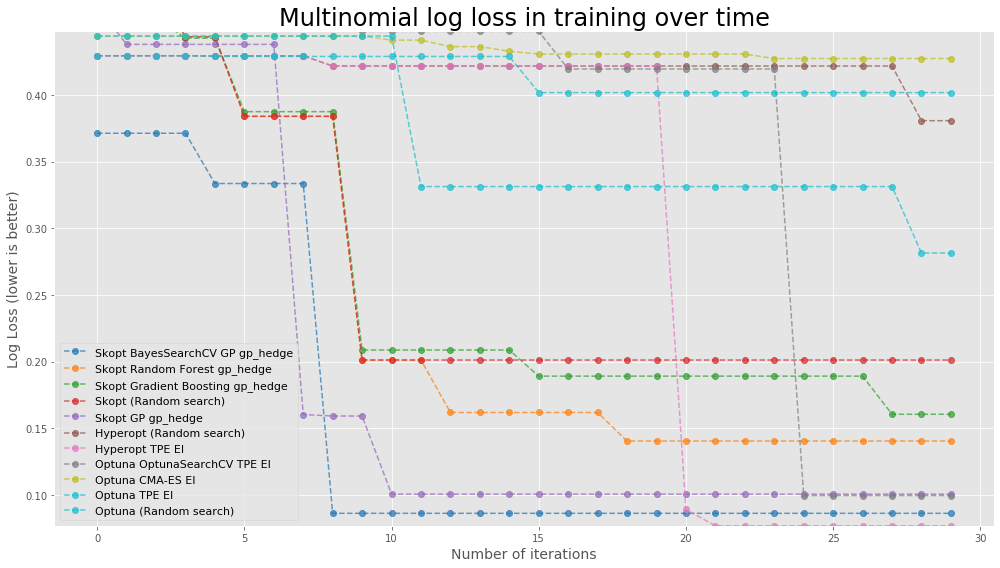

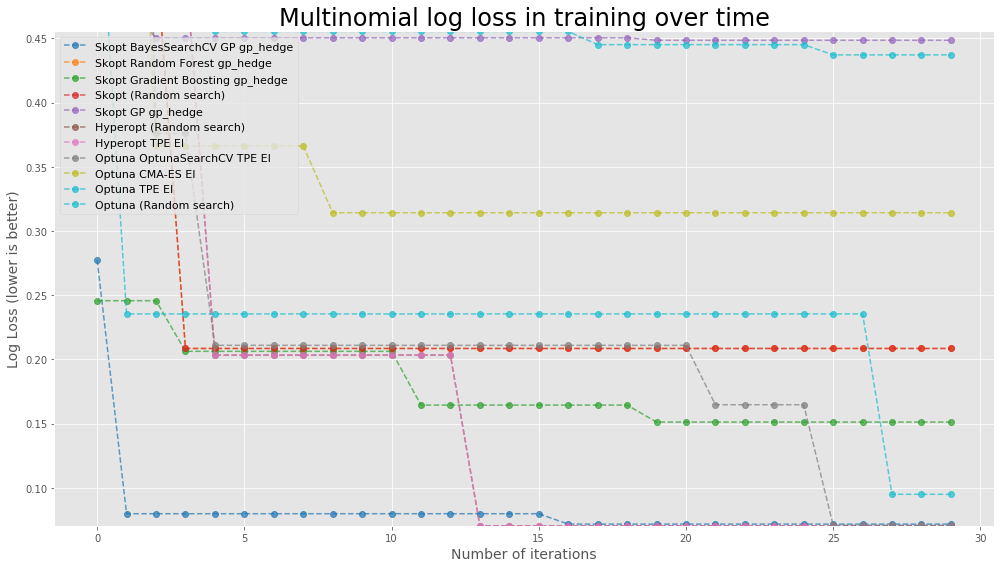

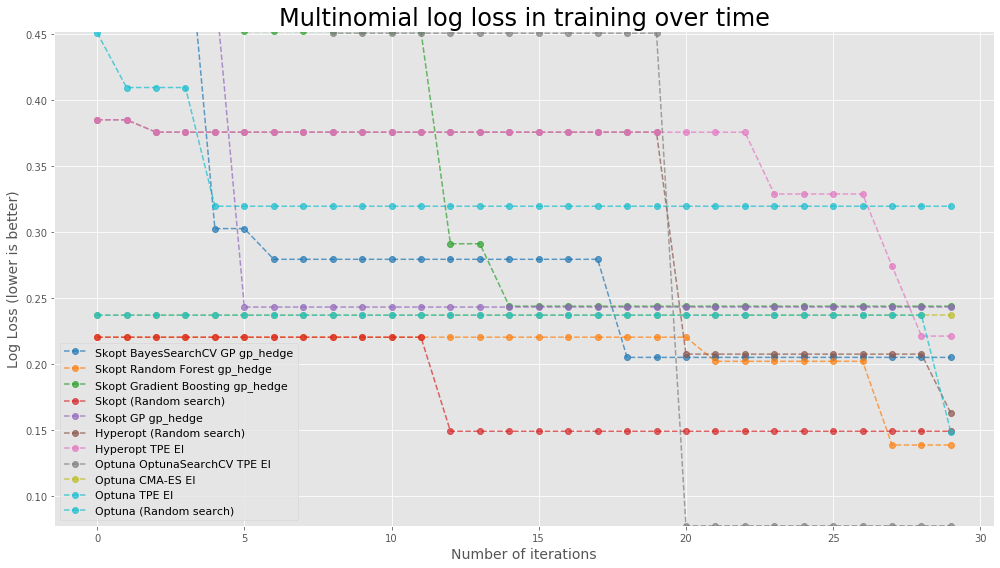

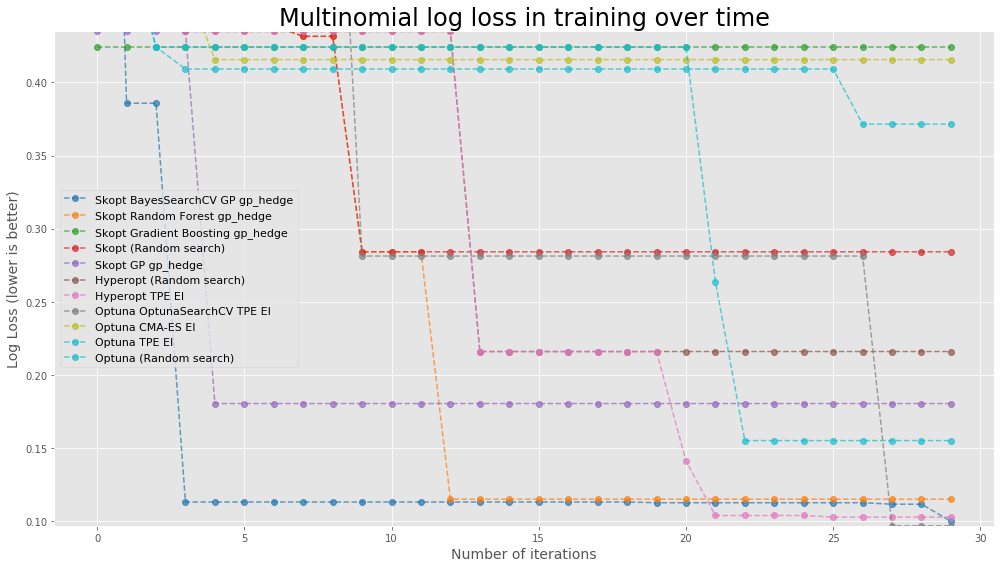

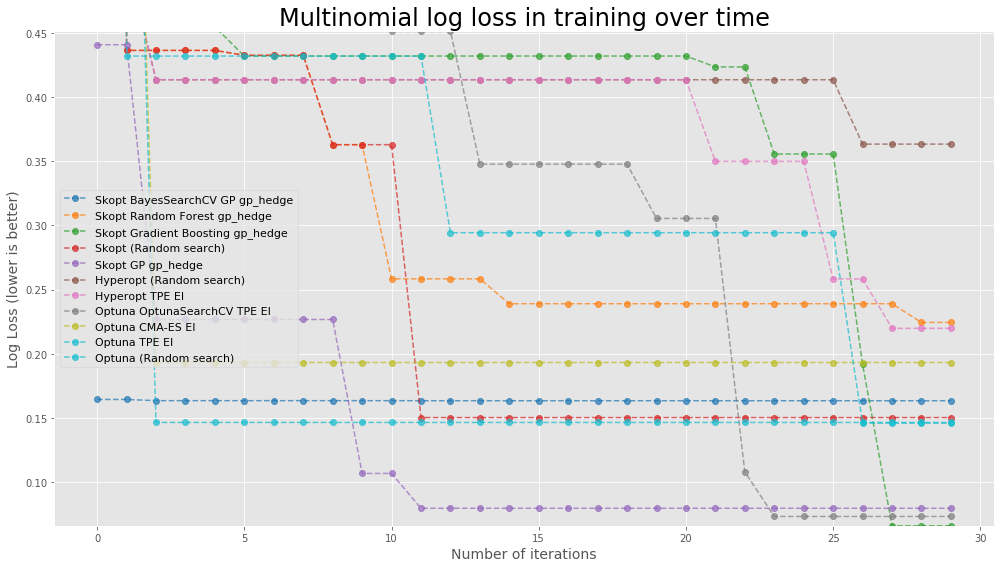

In [72]:
mdl_dct = {}

def estimate_models(export = True):
"""Loops through 5 random states, 3 datasets"""

    for dataset in ['SatImage', 'OttoGroup', 'Shuttle']: 
        print(f"> Estimating models for dataset: {dataset}\n")

        for SEED in [1991, 1992, 1993, 1994, 1995]:#  
            print(f">> Estimating models for SEED: {SEED}\n")

            baseline_model(data = dataset, SEED = SEED)
            grid_search(data = dataset, SEED = SEED)
            random_search(data = dataset, SEED = SEED)
            bayesian_search(data = dataset, SEED = SEED)

            # Skopt            
            skopt_opt(data = dataset, api_method = 'forest_minimize', surrogate = 'Random Forest'
                          , acquisition = 'gp_hedge', SEED = SEED)

            skopt_opt(data = dataset, api_method = 'gbrt_minimize', surrogate = 'Gradient Boosting'
                          , acquisition = 'gp_hedge', SEED = SEED)

            skopt_opt(data = dataset, api_method = 'gp_minimize', surrogate = 'GP'
                          , acquisition = 'gp_hedge', SEED = SEED)

            skopt_opt(data = dataset, api_method = 'dummy_minimize', surrogate = 'None (Random search)'
                          , acquisition = 'None', SEED = SEED)

            # Hyperopt ('atpe' ommited: keeps throwing errors)   
            hyperopt_opt(data = dataset, surrogate = 'None (Random search)', acquisition = 'None', SEED = SEED)
            hyperopt_opt(data = dataset, surrogate = 'TPE', acquisition = 'EI', SEED = SEED)

            # Optuna
            optuna_opt(data = dataset, surrogate = 'CMA-ES', acquisition = 'EI', SEED = SEED)
            optuna_opt(data = dataset, surrogate = 'TPE', acquisition = 'EI', SEED = SEED)
            optuna_opt(data = dataset, surrogate = 'None (Random search)', acquisition = 'None', SEED = SEED)

            # OptunaSearchCV
            optuna_search_cv(data = dataset, SEED = SEED)

            # gather results for seed
            conv_df_seed = create_conv_df(mdl_dct, dataset, SEED = SEED) 
            loss_df = create_loss_df(conv_df_seed)
            plot_loss_iters(loss_df, conv_df_seed, dataset, SEED = SEED)

            # export models
            if export:
                for m in conv_df_seed['best_model']:
                    name = (conv_df_seed.loc[conv_df_seed['best_model'] == m]['data'].map(str).values[0]\
                         + '_' \
                         + conv_df_seed.loc[conv_df_seed['best_model'] == m]['name'].map(str).str.replace(' ', '_').values[0])

                    joblib.dump(m, f"output_models\\model_{SEED}_{name}.cls")

                    # export study objects
                    study_obj = conv_df_seed.loc[conv_df_seed['best_model'] == m]['study_object'].values[0]

                    if type(study_obj) == scipy.optimize.optimize.OptimizeResult:
                        dump(study_obj, f'output_study\\study_{SEED}_{name}.pkl', store_objective = False)
                    else:
                        with bz2.BZ2File(f'output_study\\study_{SEED}_{name}.pkl', 'w') as f:
                            pickle.dump(study_obj, f)  

        # gather results dataset
        conv_df = create_conv_df(mdl_dct, dataset) 

        # plotting dataset
        create_dotplot_time(conv_df, dataset)
        create_dotplot_scores(conv_df, dataset)
        return conv_df

conv_df = estimate_models()

# End

# Notes

In [ ]:
##############################################################################
# A more complex space for hyperopt

"""
A complex search space; combining hp.choice with other sampling methods allows conditional spaces.

SPACE = hp.choice('classifier_type', [
    {
        'type': 'naive_bayes',
    },
    {
        'type': 'svm',
        'C': hp.lognormal('svm_C', 0, 1),
        'kernel': hp.choice('svm_kernel', [
            {'ktype': 'linear'},
            {'ktype': 'RBF', 'width': hp.lognormal('svm_rbf_width', 0, 1)},
            ]),
    },
    {
        'type': 'dtree',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth',
            [None, hp.qlognormal('dtree_max_depth_int', 3, 1, 1)]),
        'min_samples_split': hp.qlognormal('dtree_min_samples_split', 2, 1, 1),
    },
    ])
"""

##############################################################################
# a conditional search space for Optuna

"""
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['SVC', 'RandomForest'])
    if classifier_name == 'SVC':
        svc_c = trial.suggest_loguniform('svc_c', 1e-10, 1e10)
        classifier_obj = sklearn.svm.SVC(C=svc_c)
    else:
        rf_max_depth = int(trial.suggest_loguniform('rf_max_depth', 2, 32))
        classifier_obj = sklearn.ensemble.RandomForestClassifier(max_depth=rf_max_depth)
"""

##############################################################################
# Distributed computing for Optuna

"""
Distributed computing across cluster: create a study that resides in a database

you can  create a study in your optimization script.
By using load_if_exists=True you can treat your master script and worker 
scripts in the same way which simplifies things a lot!

# Speed and Parallelization:
/terminal 1
$ optuna create-study --study-name "distributed-search" -- storage "sqlite:///example.db"
 
/python
study = optuna.Study(study_name = "distributed-search"
                         , storage = "sqlite:///example.db"
                         , load_if_exists=True))

study.optimize(objective, n_trials = 100)

/ terminal 2
$ python optuna_search.py

/ terminal 3
$ python optune_search.py 
"""

##############################################################################
# an extended search space for Optuna (included feature vectorizer)
    
"""
tfidf__analyzer = trial.suggest_categorical('tfidf__analyzer', ['word', 'char', 'char_wb']) 
tfidf__lowercase = trial.suggest_categorical('tfidf__lowercase', [False, True]) 
tfidf__max_features = trial.suggest_int('tfidf__max_features', 500, 10_000) 
lgbc__num_leaves = trial.suggest_int('lgbc__num_leaves', 2, 150) 
lgbc__max_depth = trial.suggest_int('lgbc__max_depth', 2, 100) 
lgbc__n_estimators = trial.suggest_int('lgbc__n_estimators', 10, 200) 
lgbc__subsample_for_bin = trial.suggest_int('lgbc__subsample_for_bin', 2000, 300_000) 
lgbc__min_child_samples = trial.suggest_int('lgbc__min_child_samples', 20, 500) 
lgbc__reg_alpha = trial.suggest_uniform('lgbc__reg_alpha', 0.0, 1.0) 
lgbc__colsample_bytree = trial.suggest_uniform('lgbc__colsample_bytree', 0.6, 1.0) 
lgbc__learning_rate = trial.suggest_loguniform('lgbc__learning_rate', 1e-5, 1e-0)   

params = {
    'tfidf__analyzer': tfidf__analyzer,
    'tfidf__lowercase': tfidf__lowercase,
    'tfidf__max_features': tfidf__max_features,
    'lgbc__num_leaves': lgbc__num_leaves,
    'lgbc__max_depth': lgbc__max_depth,
    'lgbc__n_estimators': lgbc__n_estimators,
    'lgbc__subsample_for_bin': lgbc__subsample_for_bin,
    'lgbc__min_child_samples': lgbc__min_child_samples,
    'lgbc__reg_alpha': lgbc__reg_alpha,
    'lgbc__colsample_bytree': lgbc__colsample_bytree,
    'lgbc__learning_rate': lgbc__learning_rate
}
"""

##############################################################################
## BayesSearchCV /w multiple space

"""
# one can also pass a list of dicts to search_spaces param. 
# no support for nested search spaces
# runs sequentially and you cannot distribute it across machines
# you can parallelize base estimator at every run with 'n_jobs'

# setup
_lib = 'Scikit-Optimize (SKOPT)'
_api_method = 'BayesSearchCV /w multiple search space'
_surrogate = 'Gaussian Process'
_acquisition = 'gp_hedge'

pipe = Pipeline([
    ('model', LogisticRegression(multi_class = 'multinomial'))
])


logit_search = {
    'model': Categorical([LogisticRegression(random_state = SEED)]),
    'model__C': Real(1e-3, 1e+3, 'uniform')
}

# explicit dimension classes can be specified like this
lgbm_search ={
    'model': Categorical([lgb.LGBMClassifier(n_jobs = 10
                              , objective = 'multiclass'
                              , random_state= SEED)])
    ,'model__class_weight': Categorical([None, 'balanced'])
    ,'model__num_leaves': Integer(30, 150, 'log-uniform')
    ,'model__max_depth': Integer(-1, 10, 'uniform')
    ,'model__min_child_samples': Integer(20, 1000, 'log-uniform')
    ,'model__subsample_for_bin': Integer(20000, 300000, 'log-uniform')
    ,'model__n_estimators': Integer(50, 1000, 'log-uniform')
    ,'model__boosting_type': Categorical(['gbdt', 'dart', 'goss'])
    ,'model__learning_rate': Real(0.01, 0.2, 'log-uniform')
    ,'model__reg_alpha': Real(0.0, 1.0, 'uniform')
    ,'model__reg_lambda': Real(0.0, 1.0, 'uniform')
    ,'model__colsample_bytree': Real(0.6, 1.0, 'uniform')
    }


opta = BayesSearchCV(
    pipe
    , [(logit_search, 20), (lgbm_search, 30)] # (paramspace, # of evaluations)
    , cv=5
    , n_jobs = 10
    , scoring = 'neg_log_loss'
    , optimizer_kwargs = {'base_estimator': 'GP' # "GP", "RF", "ET", "GBRT"
                          , 'acq_func' : 'gp_hedge' # or "LCB", "EI", "PI", 
                          , 'random_state': SEED} # would use a Random Forest     
    , random_state = SEED
)

opta.fit(X_train, y_train)
"""